# **Setup**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import os
import re
import ast

import matplotlib.pyplot as plt
import seaborn as sns

# **Explicit Topic Search & Sentiment Analysis**

## **ChatGPT**

## Call saved values

In [3]:
file_path = '/content/drive/MyDrive/Portfolio Projects/Mestrado/Temp/df_topicos_qna_sentiment.csv'
df_merge = pd.read_csv(file_path)

null_list = ['prbc-2012-1', 'bpan-2017-4', 'bpan-2018-1', 'bpan-2017-2', 'brsr-2015-4',
             'itub-2019-1', 'bpan-2016-1', 'bpan-2017-1','bpan-2016-2', 'brsr-2014-1',
             'bpan-2016-3', 'bpan-2017-3', 'brsr-2008-1', 'brsr-2014-2']

df_merge = df_merge[~df_merge['doc'].isin(null_list)]

In [4]:
def safe_eval(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return x

df_merge['response'] = df_merge['response'].apply(safe_eval)

In [5]:
sentiment_mapping = {'Positivo':'Sim',
                     'Negativo':'Não'}
df_gpt = pd.DataFrame(columns=['doc', 'topic', 'present', 'sentiment'])

cont = 0
total_files = 0
for index, row in df_merge.iterrows():
    total_files += 1
    doc = row['doc']
    dic = row['response']
    if isinstance(dic, str):

      dic = dic.replace('json','')
      dic = dic.replace('json','')
      dic = dic.replace('```','')
      dic = dic.replace('// SME mencionado como SMI, mas considerado como o mesmo termo','')
      dic = dic.replace("'Não,","'Não',")
      #dic = dic.replace('\n','')

      dic = safe_eval(dic)

    if isinstance(dic, dict):
        for t in dic:
            topic = t
            present = dic[t][0]
            sentiment = dic[t][1]

            new_row = pd.DataFrame({'doc': [doc], 'topic': [topic], 'present': [present], 'sentiment': [sentiment]})
            df_gpt = pd.concat([df_gpt, new_row], ignore_index=True)
    else:
      cont += 1
      dic
      print(doc, type(dic), dic)
      pass

df_gpt['present'] = df_gpt['present'].apply(lambda x: 'Sim' if x == 'Sim ' else x)
df_gpt['sentiment'] = df_gpt['sentiment'].replace(sentiment_mapping)
df_gpt['bank'] = df_gpt['doc'].apply(lambda x:x.split('-')[0])
df_gpt['year'] = df_gpt['doc'].apply(lambda x:x.split('-')[1])
df_gpt['trimester'] = df_gpt['doc'].apply(lambda x:x.split('-')[2])

In [44]:
#% of Problems:
print(f'{round(cont/total_files*100,2)}%')

20.5%


## **Llama**

### Call & Clean Outputs

In [6]:
transcript_qna_folder = '/content/drive/MyDrive/Portfolio Projects/Mestrado/Outputs/llama/'

files = os.listdir(transcript_qna_folder)
#files = files[0:5]

#df_info = pd.DataFrame(columns=['doc','response'])
df_info = pd.DataFrame()

null_list = ['prbc-2012-1', 'bpan-2017-4', 'bpan-2018-1', 'bpan-2017-2', 'brsr-2015-4',
             'itub-2019-1', 'bpan-2016-1', 'bpan-2017-1','bpan-2016-2', 'brsr-2014-1',
             'bpan-2016-3', 'bpan-2017-3', 'brsr-2008-1', 'brsr-2014-2']

problematic = ['bbas-2011-3', 'prbc-2010-2']
not_contained = ['prbc-2012-1','brsr-2018-2']
add_brackets = ['bpan-2017-3','brsr-2014-1']
check_later = ['brsr-2020-1','bbas-2009-3','bpan-2017-4','bpan-2016-2','bpan-2017-1',
 'bpan-2018-1','bbas-2011-2','bpan-2012-4','itub-2019-1','bpan-2017-3','brsr-2014-1']
pass_list = problematic + not_contained + add_brackets + check_later


cont = 0
problems = []
files = files[:-1]
for i in null_list:
  files.remove(i + '.txt_output.txt')
num_files = len(files)
for i, file in enumerate(files):
    print(file)
    path_transcription = transcript_qna_folder + file

    file_name_parts = file.split("-")
    print(file_name_parts)
    ticker           = file_name_parts[0].strip()
    year             = file_name_parts[1].strip()
    trimester        = file_name_parts[2].strip()[0]

    doc = f'{ticker}-{year}-{trimester}'
    #print(doc)
    #print(f'Processing file {i} of {num_files}')
    #print(file_name_parts)
    if f'{ticker}-{year}-{trimester}' not in pass_list:
      with open(path_transcription, 'r') as file:
        text = file.read()

        #text = '{' + text.split('{', 1)[1]

        text = text.replace('\n\n', '').replace('\n', '')
        text = re.sub(r'\n+', '', text)
        text = re.sub(r'[\r\n]+', '', text)
        text = text.replace('\\n\\n', '').replace('\\n', '')
        match = re.search(r'\{.*?\}', text)  # Match everything between { and }, including braces
        if match:
            text = match.group(0)  # Get the matched part


        text = text.replace('False','Não')
        text = text.replace('True','Sim')
        text = text.replace('Nenhum dos dois','Não')
        text = text.replace('Nenhum dos dois','Não')
        text = text.replace("'Não'",'Não')
        text = text.replace("'Sim'",'Sim')
        text = text.replace('Não',"'Não'")
        text = text.replace('Sim',"'Sim'")
        text = text.replace('Nenhum','Não')
        text = text.replace('Nem','')
        text = text.replace('nem','')
        text = text.replace("[' 'Sim'  'Não'']","['Sim', 'Não']")
        text = text.replace("'Não desses palavras foi mencionado na transcrição'","'Não','Não'")
        text = text.replace("'Não menção'","'Não','Não'")

        #text = text.replace('Aqui está a resposta solicitada:','')

        #print(text)

        try:
          dictionary = ast.literal_eval(text)
          #print(type(dictionary))

          dff = pd.DataFrame(dictionary)
          dff.index = ['present', 'sentiment']
          pivoted = dff.T.reset_index().rename(columns={'index': 'topic'})
          pivoted['doc'] = f'{ticker}-{year}-{trimester}'
          pivoted = pivoted[['doc','topic','present','sentiment']]

          df_info = pd.concat([df_info, pivoted])
          #print(df_info)
        except:
          print(f'{ticker}-{year}-{trimester}')
          check_later.append([f'{ticker}-{year}-{trimester}'])
          #print(repr(text))
          #print(text)
          cont += 1
          problems.append(text)
          pass

df_llama = df_info.copy()

brsr-2015-1.txt_output.txt
['brsr', '2015', '1.txt_output.txt']
bbdc-2022-2.txt_output.txt
['bbdc', '2022', '2.txt_output.txt']
itub-2012-3.txt_output.txt
['itub', '2012', '3.txt_output.txt']
bbas-2020-1.txt_output.txt
['bbas', '2020', '1.txt_output.txt']
itub-2012-4.txt_output.txt
['itub', '2012', '4.txt_output.txt']
bbas-2020-3.txt_output.txt
['bbas', '2020', '3.txt_output.txt']
brsr-2012-4.txt_output.txt
['brsr', '2012', '4.txt_output.txt']
bbdc-2023-1.txt_output.txt
['bbdc', '2023', '1.txt_output.txt']
sanb-2023-2.txt_output.txt
['sanb', '2023', '2.txt_output.txt']
bbas-2012-1.txt_output.txt
['bbas', '2012', '1.txt_output.txt']
bbas-2018-1.txt_output.txt
['bbas', '2018', '1.txt_output.txt']
abcb-2016-3.txt_output.txt
['abcb', '2016', '3.txt_output.txt']
bbdc-2022-1.txt_output.txt
['bbdc', '2022', '1.txt_output.txt']
brsr-2010-4.txt_output.txt
['brsr', '2010', '4.txt_output.txt']
brsr-2010-1.txt_output.txt
['brsr', '2010', '1.txt_output.txt']
bmgb-2019-1.txt_output.txt
['bmgb', '201

In [7]:
#% of Problems:
print(f'{round(len(pass_list)/num_files*100,2)}%')

4.71%


In [8]:
#Organize df
df_llama['bank'] = df_llama['doc'].apply(lambda x:x.split('-')[0])
df_llama['year'] = df_llama['doc'].apply(lambda x:x.split('-')[1])
df_llama['trimester'] = df_llama['doc'].apply(lambda x:x.split('-')[2])
df_llama['sentiment'] = df_llama.apply(lambda x: 'Não' if (pd.isna(x['sentiment']) and x['present'] == 'Não') else x['sentiment'], axis=1)

### Standardize Topics

In [9]:
category_mapping = {'Measures do governo':'Medidas do governo',
                    'Meidas do governo':'Medidas do governo',
                    ' Medidas do governo': 'Medidas do governo',
                    'Segmento de veiculos':'Segmento de veículos',
                    'Segimento de veículos':'Segmento de veículos',
                    'Segmente de veículo':'Segmento de veículos',
                    'Segmente de veículos':'Segmento de veículos',
                    'Segmento imobiliario':'Segmento imobiliário',
                    'Veículos':'Segmento de veículos',
                    'Inadimplencia':'Inadimplência',
                    ' Despesas administrativas':'Despesas administrativas',
                    ' Custo de captação': 'Custo de captação',
                    ' Equilíbrio fiscal':'Equilíbrio fiscal',
                    ' Segmento de veículos':'Segmento de veículos',
                    ' SME':'SME', ' Corporate':'Corporate',' Câmbio':'Câmbio',
                    ' Inadimplência':'Inadimplência',' Gestão de risco':'Gestão de risco',
                    ' Taxa Selic':'Taxa Selic',' Segmento imobiliário':'Segmento imobiliário',
                    ' Cartão de crédito':'Cartão de crédito', ' Provisões de Risco':'Provisões de Risco',
                    ' Middle Market':'Middle Market'}
df_llama['topic'] = df_llama['topic'].replace(category_mapping)

In [10]:
category_mapping = {'SIM':'Sim',
                    'NÃO':'Não',
                    'Nao': 'Não',
                    'Não comentário':'Não',
                    -1:'Não',
                    0:'Não',
                    1:'Sim',
                    'Nãoa menção': 'Não'}
df_llama['present'] = df_llama['present'].replace(category_mapping)

In [11]:
category_mapping = {'SIM':'Sim',
                    'Positiva':'Sim',
                    'Negativa':'Não',
                    'Positivo':'Sim',
                    'Negativo':'Não',
                    'NÃO':'Não',
                    'Nao': 'Não',
                    'Não comentário':'Não',
                    -1:'Não',
                    0:'Não',
                    1:'Sim',
                    'Nãoa menção': 'Não',
                    'Não comentário positivo ou negativo sobre o segmento de veículos foi mencionado no arquivo.':'Não',
                    'Não comentário positivo ou negativo sobre a Corporate foi mencionado no arquivo.':'Não',
                    'Não comentário positivo ou negativo sobre a gestão de risco foi mencionado no arquivo.':'Não',
                    'Não comentário positivo ou negativo sobre as despesas administrativas foi mencionado no arquivo.':'Não',
                    'Não comentário positivo ou negativo sobre o custo de captação foi mencionado no arquivo.':'Não',
                    'Não comentário positivo ou negativo sobre o equilíbrio fiscal foi mencionado no arquivo.':'Não',
                    'Não comentário positivo ou negativo sobre as medidas do governo foi mencionado no arquivo.':'Não',
                    'Não menção a aspectos positivos ou negativos': 'Não',
                    'Não comentário sobre positividade/negatividade': 'Não',
                    'Custo de captação está diminuindo, especialmente em relação ao segmento imobiliário':'Sim',
                    'Impacto positivo na rentabilidade dos produtos de crédito e no nível de inadimplência':'Sim',
                    'Não menção negativa': 'Não',
                    None:'Não',
                    'Não comentário': 'Não',
                    'Não comentário específico': 'Não',
                     'Nãoa menção negativa': 'Não',
                     '-': 'Não',
                     'Nega': 'Não',
                    'N/A': 'Não',
                     'Não menção específica': 'Não',
                     'Nãoa menção específica': 'Não',
                    'Nãp': 'Não',
                    'Aumento das despesas com a implementação da RSI e do PPS, mas o nível de despesa foi ajustado para manter os resultados dentro dos limites previstos':'Não'
                    }
df_llama['sentiment'] = df_llama['sentiment'].replace(category_mapping)

## **Qwen**

### Call & Clean Outputs

In [12]:
transcript_qna_folder = '/content/drive/MyDrive/Portfolio Projects/Mestrado/Outputs/qwen/'

files = os.listdir(transcript_qna_folder)
#files = files[0:5]

#df_info = pd.DataFrame(columns=['doc','response'])
df_info = pd.DataFrame()

null_list = ['prbc-2012-1', 'bpan-2017-4', 'bpan-2018-1', 'bpan-2017-2', 'brsr-2015-4',
             'itub-2019-1', 'bpan-2016-1', 'bpan-2017-1','bpan-2016-2', 'brsr-2014-1',
             'bpan-2016-3', 'bpan-2017-3', 'brsr-2008-1', 'brsr-2014-2']

problematic = ['bbas-2011-3', 'prbc-2010-2']
not_contained = ['prbc-2012-1','brsr-2018-2']
add_brackets = ['bpan-2017-3','brsr-2014-1']
check_later = ['brsr-2020-1','bbas-2009-3','bpan-2017-4','bpan-2016-2','bpan-2017-1',
 'bpan-2018-1','bbas-2011-2','bpan-2012-4','itub-2019-1','bpan-2017-3','brsr-2014-1']
pass_list = problematic + not_contained + add_brackets + check_later


cont = 0
problems = []
files = files[:-1]
for i in null_list:
  files.remove(i + '.txt_output.txt')
num_files = len(files)
for i, file in enumerate(files):
    print(file)
    path_transcription = transcript_qna_folder + file

    file_name_parts = file.split("-")
    print(file_name_parts)
    ticker           = file_name_parts[0].strip()
    year             = file_name_parts[1].strip()
    trimester        = file_name_parts[2].strip()[0]

    doc = f'{ticker}-{year}-{trimester}'
    #print(doc)
    #print(f'Processing file {i} of {num_files}')
    #print(file_name_parts)
    if f'{ticker}-{year}-{trimester}' not in pass_list:
      with open(path_transcription, 'r') as file:
        text = file.read()

        #text = '{' + text.split('{', 1)[1]

        text = text.replace('\n\n', '').replace('\n', '')
        text = re.sub(r'\n+', '', text)
        text = re.sub(r'[\r\n]+', '', text)
        text = text.replace('\\n\\n', '').replace('\\n', '')
        match = re.search(r'\{.*?\}', text)  # Match everything between { and }, including braces
        if match:
            text = match.group(0)  # Get the matched part


        text = text.replace('False','Não')
        text = text.replace('True','Sim')
        text = text.replace('Nenhum dos dois','Não')
        text = text.replace('Nenhum dos dois','Não')
        text = text.replace("'Não'",'Não')
        text = text.replace("'Sim'",'Sim')
        text = text.replace('Não',"'Não'")
        text = text.replace('Sim',"'Sim'")
        text = text.replace('Nenhum','Não')
        text = text.replace('Nem','')
        text = text.replace('nem','')
        text = text.replace("[' 'Sim'  'Não'']","['Sim', 'Não']")
        text = text.replace("'Não desses palavras foi mencionado na transcrição'","'Não','Não'")
        text = text.replace("'Não menção'","'Não','Não'")

        #text = text.replace('Aqui está a resposta solicitada:','')

        #print(text)

        try:
          dictionary = ast.literal_eval(text)
          #print(type(dictionary))

          dff = pd.DataFrame(dictionary)
          dff.index = ['present', 'sentiment']
          pivoted = dff.T.reset_index().rename(columns={'index': 'topic'})
          pivoted['doc'] = f'{ticker}-{year}-{trimester}'
          pivoted = pivoted[['doc','topic','present','sentiment']]

          df_info = pd.concat([df_info, pivoted])
          #print(df_info)
        except:
          print(f'{ticker}-{year}-{trimester}')
          check_later.append([f'{ticker}-{year}-{trimester}'])
          #print(repr(text))
          #print(text)
          cont += 1
          problems.append(text)
          pass

df_qwen = df_info.copy()

brsr-2015-1.txt_output.txt
['brsr', '2015', '1.txt_output.txt']
bbdc-2022-2.txt_output.txt
['bbdc', '2022', '2.txt_output.txt']
itub-2012-3.txt_output.txt
['itub', '2012', '3.txt_output.txt']
bbas-2020-1.txt_output.txt
['bbas', '2020', '1.txt_output.txt']
itub-2012-4.txt_output.txt
['itub', '2012', '4.txt_output.txt']
bbas-2020-3.txt_output.txt
['bbas', '2020', '3.txt_output.txt']
brsr-2012-4.txt_output.txt
['brsr', '2012', '4.txt_output.txt']
bbdc-2023-1.txt_output.txt
['bbdc', '2023', '1.txt_output.txt']
sanb-2023-2.txt_output.txt
['sanb', '2023', '2.txt_output.txt']
bbas-2012-1.txt_output.txt
['bbas', '2012', '1.txt_output.txt']
bbas-2018-1.txt_output.txt
['bbas', '2018', '1.txt_output.txt']
abcb-2016-3.txt_output.txt
['abcb', '2016', '3.txt_output.txt']
bbdc-2022-1.txt_output.txt
['bbdc', '2022', '1.txt_output.txt']
brsr-2010-4.txt_output.txt
['brsr', '2010', '4.txt_output.txt']
brsr-2010-1.txt_output.txt
['brsr', '2010', '1.txt_output.txt']
bmgb-2019-1.txt_output.txt
['bmgb', '201

In [13]:
#% of Problems:
print(f'{round(len(pass_list)/num_files*100,2)}%')

4.71%


In [14]:
#Organize df
df_qwen['bank'] = df_qwen['doc'].apply(lambda x:x.split('-')[0])
df_qwen['year'] = df_qwen['doc'].apply(lambda x:x.split('-')[1])
df_qwen['trimester'] = df_qwen['doc'].apply(lambda x:x.split('-')[2])
df_qwen['present'] = df_qwen['present'].apply(lambda x: "Não" if x == "'Não'" else x)
df_qwen['present'] = df_qwen['present'].apply(lambda x: "Sim" if x == "'Sim'" else x)
df_qwen['sentiment'] = df_qwen.apply(lambda x: 'Não' if (pd.isna(x['sentiment']) and x['present'] == 'Não') else x['sentiment'], axis=1)

In [15]:
category_mapping = {'Positivo':'Sim',
                    "'Sim'":'Sim',
                    "'Não'":'Não',
                    'Neutral': 'Neutro',
                    'Indiferente':'Neutro',
                    'Positivo/Negativo':'Neutro',
                    'N/A':'Nulo',
                    'Indisponível':'Nulo',
                    'Não texto mencionado':'Nulo',
                    'N/I':'Nulo',
                    'Neutro/Negativo':'Não',
                    'Negativo':'Não',
                    'Não comentário': 'Nulo'}
df_qwen['sentiment'] = df_qwen['sentiment'].replace(category_mapping)

### Standardize Topics

In [16]:
df_qwen.head()

,doc,topic,present,sentiment,bank,year,trimester
0,brsr-2015-1,Segmento agro,Sim,Sim,brsr,2015,1
1,brsr-2015-1,Segmento imobiliário,Sim,Não,brsr,2015,1
2,brsr-2015-1,Segmento de veículos,Não,Não,brsr,2015,1
3,brsr-2015-1,Middle Market,Sim,Sim,brsr,2015,1
4,brsr-2015-1,Corporate,Sim,Não,brsr,2015,1


## Aggregation

# Nova seção

# Nova seção

In [17]:
df_qwen['present'].unique()

array(['Sim', 'Não'], dtype=object)

In [18]:
x = df_gpt.copy()
x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['sentiment'] = x['sentiment'].apply(lambda x: 0 if x == 'Não' else 0)
x.head()

,doc,topic,present,sentiment,bank,year,trimester
0,bmgb-2022-2,Segmento agro,0,0,bmgb,2022,2
1,bmgb-2022-2,Segmento imobiliário,0,0,bmgb,2022,2
2,bmgb-2022-2,Segmento de veículos,0,0,bmgb,2022,2
3,bmgb-2022-2,Middle Market,1,0,bmgb,2022,2
4,bmgb-2022-2,Corporate,1,0,bmgb,2022,2


In [19]:
x = df_gpt.copy()
x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
#x['sentiment'] = x['sentiment'].apply(lambda x: 0 if x == 'Não' else 0)

y = df_llama.copy()
y['present'] = y['present'].apply(lambda x: 1 if x == 'Sim' else 0)
#y['sentiment'] = y['sentiment'].apply(lambda x: 0 if x == 'Não' else 0)

z = df_qwen.copy()
z['present'] = z['present'].apply(lambda x: 1 if x == 'Sim' else 0)
#z['sentiment'] = z['sentiment'].apply(lambda x: 0 if x == 'Não' else 0)

In [20]:
df_merge =   x.merge(y, on = ['doc','topic','bank','year','trimester'], how = 'inner', suffixes = ('_gpt', '_llama'))
df_merge = df_merge.merge(z, on = ['doc','topic','bank','year','trimester'], how = 'inner', suffixes = ('_merge', '_qwen'))
df_merge.rename(columns={'present':'present_qwen','sentiment':'sentiment_qwen'}, inplace=True)
df_merge.head()

,doc,topic,present_gpt,sentiment_gpt,bank,year,trimester,present_llama,sentiment_llama,present_qwen,sentiment_qwen
0,bmgb-2022-2,Segmento agro,0,Não,bmgb,2022,2,0,Não,1,Sim
1,bmgb-2022-2,Segmento imobiliário,0,Não,bmgb,2022,2,0,Não,1,Não
2,bmgb-2022-2,Segmento de veículos,0,Não,bmgb,2022,2,0,Não,0,Neutro
3,bmgb-2022-2,Middle Market,1,Sim,bmgb,2022,2,1,Sim,1,Sim
4,bmgb-2022-2,Corporate,1,Sim,bmgb,2022,2,1,Sim,1,Neutro


In [22]:
dff = df_merge.copy()
dff['match_gpt_llama'] = dff.apply(lambda x: 1 if x['present_gpt'] == x['present_llama'] else 0, axis=1)
dff['match_gpt_qwen'] = dff.apply(lambda x: 1 if x['present_gpt'] == x['present_qwen'] else 0, axis=1)
dff['match_llama_qwen'] = dff.apply(lambda x: 1 if x['present_llama'] == x['present_qwen'] else 0, axis=1)

match_gpt_llama  = round(dff['match_gpt_llama'].mean(),2)
match_gpt_qwen   = round(dff['match_gpt_qwen'].mean(),2)
match_llama_qwen = round(dff['match_llama_qwen'].mean(),2)
print('match_gpt_llama:', match_gpt_llama)
print( 'match_gpt_qwen: ', match_gpt_qwen)
print('match_llama_qwen:',match_llama_qwen)

match_gpt_llama: 0.53
match_gpt_qwen:  0.44
match_llama_qwen: 0.66


In [23]:
df_merge['present_majority'] = df_merge.apply(lambda x: 1 if x['present_gpt'] + x['present_llama'] + x['present_qwen'] else 0, axis=1)

dff = df_merge.copy()
dff['match_gpt_majority']   = dff.apply(lambda x: 1 if x['present_gpt'] == x['present_majority'] else 0, axis=1)
dff['match_llama_majority'] = dff.apply(lambda x: 1 if x['present_llama'] == x['present_majority'] else 0, axis=1)
dff['match_qwen_majority']  = dff.apply(lambda x: 1 if x['present_qwen'] == x['present_majority'] else 0, axis=1)

match_gpt_llama  = round(dff['match_gpt_majority'].mean(),2)
match_gpt_qwen   = round(dff['match_llama_majority'].mean(),2)
match_llama_qwen = round(dff['match_qwen_majority'].mean(),2)
print(match_gpt_llama, match_gpt_qwen, match_llama_qwen)

0.46 0.67 0.93


In [24]:
df_gt = pd.read_csv('/content/drive/MyDrive/Portfolio Projects/Mestrado/Notebooks/final_code/structured/Ground Truth.csv', sep = ';')
df_gt = df_gt.iloc[:480,1:7]
df_gt.rename(columns={'Nº':'n','Document':'doc','Bank':'bank','Year':'year','Trimester':'trimester','Topic':'topic','Present':'present'},inplace=True)
df_gt['present'] = df_gt['present'].astype(int)
df_gt['year'] = df_gt['year'].astype(int)
df_gt['trimester'] = df_gt['trimester'].astype(int)
df_gt['doc'] = df_gt['doc'].apply(lambda x: x[2:-2].replace('T',''))
df_gt.head()

,doc,bank,year,trimester,topic,present
0,abcb-2009-1,abcb,2009,1,Segmento agro,0
1,abcb-2009-1,abcb,2009,1,Segmento imobiliário,0
2,abcb-2009-1,abcb,2009,1,Segmento de veículos,0
3,abcb-2009-1,abcb,2009,1,Middle Market,1
4,abcb-2009-1,abcb,2009,1,Corporate,1


In [28]:
#df_gpt[df_gpt['bank'] == 'brsr'][df_gpt['year'] == '2007']

In [29]:
#df_gt[df_gt['bank'] == 'brsr']

In [31]:
x = df_gpt.copy()
x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x.drop(['bank','year','trimester'], axis=1, inplace=True)

y = df_llama.copy()
y['present'] = y['present'].apply(lambda x: 1 if x == 'Sim' else 0)
y.drop(['bank','year','trimester'], axis=1, inplace=True)

z = df_qwen.copy()
z['present'] = z['present'].apply(lambda x: 1 if x == 'Sim' else 0)
z.drop(['bank','year','trimester'], axis=1, inplace=True)


In [33]:
df_merge = x.merge(y, on = ['doc','topic'], how = 'inner', suffixes = ('_gpt', '_llama'))
df_merge = df_merge.merge(z, on = ['doc','topic'], how = 'inner', suffixes = ('_merge', '_qwen'))
df_merge.rename(columns={'present':'present_qwen','sentiment':'sentiment_qwen'}, inplace=True)

df_agg_gt = df_merge.merge(df_gt[['doc','topic','present']], on =['doc','topic'],how='left',suffixes=('_gpt','_gt'))
df_agg_gt = df_agg_gt[df_agg_gt['present'].notnull()]
df_agg_gt.head()

,doc,topic,present_gpt,sentiment_gpt,present_llama,sentiment_llama,present_qwen,sentiment_qwen,present
0,bmgb-2022-2,Segmento agro,0,Não,0,Não,1,Sim,0.0
1,bmgb-2022-2,Segmento imobiliário,0,Não,0,Não,1,Não,0.0
2,bmgb-2022-2,Segmento de veículos,0,Não,0,Não,0,Neutro,0.0
3,bmgb-2022-2,Middle Market,1,Sim,1,Sim,1,Sim,1.0
4,bmgb-2022-2,Corporate,1,Sim,1,Sim,1,Neutro,0.0


In [93]:
null_list = ['prbc-2012-1', 'bpan-2017-4', 'bpan-2018-1', 'bpan-2017-2', 'brsr-2015-4',
             'itub-2019-1', 'bpan-2016-1', 'bpan-2017-1','bpan-2016-2', 'brsr-2014-1',
             'bpan-2016-3', 'bpan-2017-3', 'brsr-2008-1', 'brsr-2014-2']

problematic = ['bbas-2011-3', 'prbc-2010-2']
not_contained = ['prbc-2012-1','brsr-2018-2']
add_brackets = ['bpan-2017-3','brsr-2014-1']
check_later = ['brsr-2020-1','bbas-2009-3','bpan-2017-4','bpan-2016-2','bpan-2017-1',
 'bpan-2018-1','bbas-2011-2','bpan-2012-4','itub-2019-1','bpan-2017-3','brsr-2014-1']

280

In [41]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

models = ['gpt', 'llama','qwen']
for model in models:
  y_true = df_agg_gt['present']
  y_pred = df_agg_gt['present_'+ model]

  print(model)
  print('f1_score:', round(f1_score(y_true, y_pred),2))
  print('accuracy_score:', round(accuracy_score(y_true, y_pred),2))
  confusion_matrix(y_true, y_pred)

gpt
f1_score: 0.76
accuracy_score: 0.77
llama
f1_score: 0.68
accuracy_score: 0.63
qwen
f1_score: 0.7
accuracy_score: 0.57


In [48]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

models = ['gpt', 'llama','qwen']
topics = df_agg_gt['topic'].unique()
metrics = {}

for model in models:
  print(model)
  metrics[model] = {}
  for topic in topics:
    df_agg_gt_topic = df_agg_gt[df_agg_gt['topic'] == topic]
    y_true = df_agg_gt_topic['present']
    y_pred = df_agg_gt_topic['present_'+ model]

    metrics[model][topic] = round(accuracy_score(y_true, y_pred),2)
    #metrics[model][topic]['accuracy_score'] = round(accuracy_score(y_true, y_pred),2)
    print(topic, round(accuracy_score(y_true, y_pred),2))
    confusion_matrix(y_true, y_pred)

gpt
Segmento agro 0.96
Segmento imobiliário 0.83
Segmento de veículos 0.91
Middle Market 0.7
Corporate 0.74
Gestão de risco 0.35
Inadimplência 0.87
Despesas administrativas 0.7
Custo de captação 0.7
Provisões de Risco 0.91
Taxa Selic 0.91
SME 0.74
Equilíbrio fiscal 0.7
Medidas do governo 0.57
Câmbio 0.87
Cartão de crédito 0.87
llama
Segmento agro 0.78
Segmento imobiliário 0.48
Segmento de veículos 0.64
Middle Market 0.7
Corporate 0.87
Gestão de risco 0.52
Inadimplência 0.65
Despesas administrativas 0.57
Custo de captação 0.57
Provisões de Risco 0.61
Taxa Selic 0.78
SME 0.48
Equilíbrio fiscal 0.48
Medidas do governo 0.61
Câmbio 0.57
Cartão de crédito 0.87
qwen
Segmento agro 0.39
Segmento imobiliário 0.48
Segmento de veículos 0.68
Middle Market 0.65
Corporate 0.78
Gestão de risco 0.22
Inadimplência 0.78
Despesas administrativas 0.57
Custo de captação 0.65
Provisões de Risco 0.78
Taxa Selic 0.7
SME 0.52
Equilíbrio fiscal 0.52
Medidas do governo 0.78
Câmbio 0.17
Cartão de crédito 0.48


In [53]:
df_topic_metrics = pd.DataFrame(metrics)
df_topic_metrics['avg'] = round(df_topic_metrics.mean(axis=1),2)
df_topic_metrics.head(16)

,gpt,llama,qwen,avg
Segmento agro,0.96,0.78,0.39,0.71
Segmento imobiliário,0.83,0.48,0.48,0.60
Segmento de veículos,0.91,0.64,0.68,0.74
Middle Market,0.70,0.70,0.65,0.68
Corporate,0.74,0.87,0.78,0.80
Gestão de risco,0.35,0.52,0.22,0.36
Inadimplência,0.87,0.65,0.78,0.77
Despesas administrativas,0.70,0.57,0.57,0.61
Custo de captação,0.70,0.57,0.65,0.64
Provisões de Risco,0.91,0.61,0.78,0.77


## Plots

In [57]:
sns.set_style('whitegrid')

In [19]:
df_llama.head()

,doc,topic,present,sentiment,bank,year,trimester
0,brsr-2015-1,Segmento agro,Não,Não,brsr,2015,1
1,brsr-2015-1,Segmento imobiliário,Não,Não,brsr,2015,1
2,brsr-2015-1,Segmento de veículos,Não,Não,brsr,2015,1
3,brsr-2015-1,Middle Market,Sim,Não,brsr,2015,1
4,brsr-2015-1,Corporate,Sim,Não,brsr,2015,1


### ChatGPT

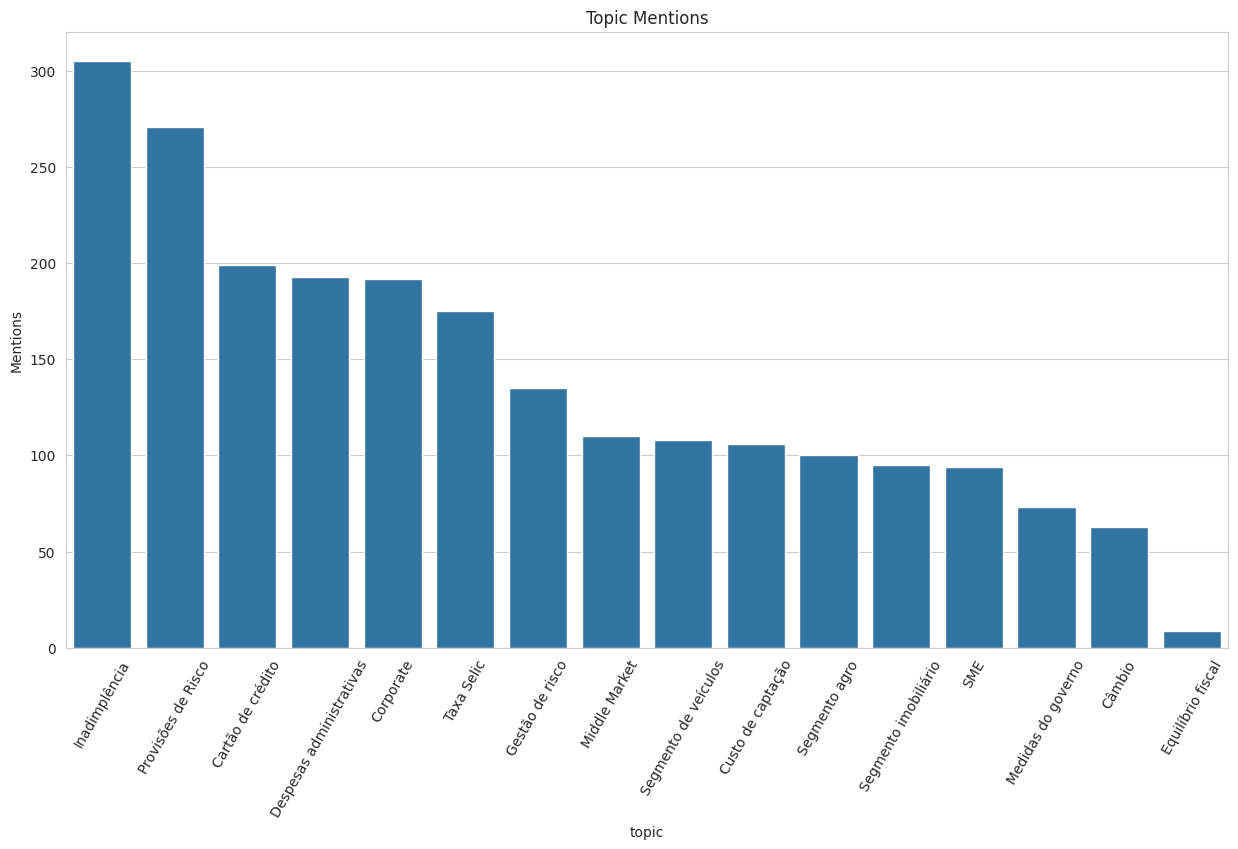

In [20]:
x = df_gpt.copy()
x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['sentiment'] = x['sentiment'].apply(lambda x: 1 if x == 'Sim' else 0)
x = x.groupby('topic').agg({'present':'sum'}).reset_index().sort_values('present', ascending=False)

plt.figure(figsize=(15,8))
sns.barplot(data = x, x = 'topic', y = 'present')
plt.title(f'Topic Mentions')
plt.ylabel('Mentions')
plt.xticks(rotation=60)
plt.show()

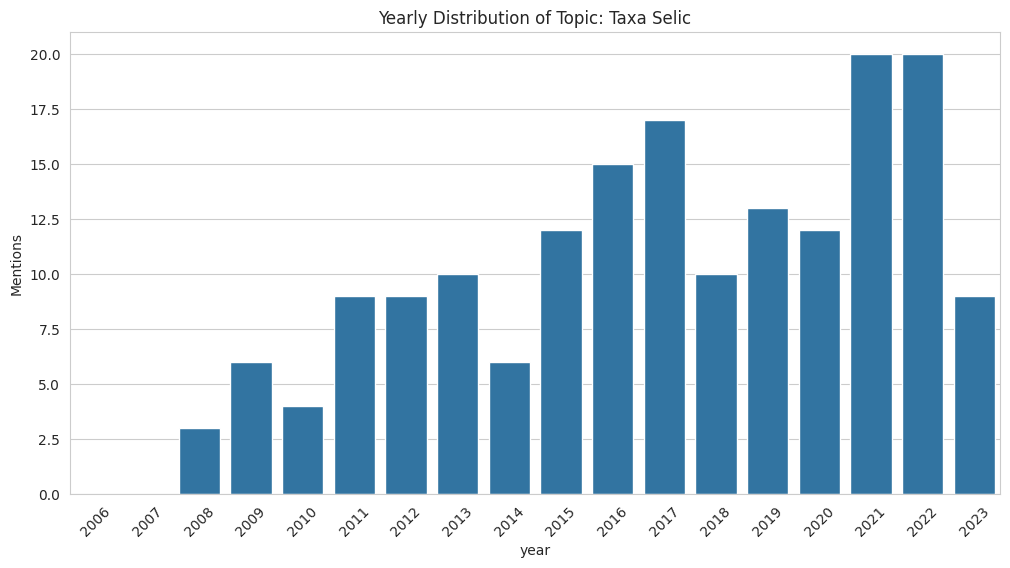

In [21]:
cat = 'Taxa Selic'
x = df_gpt[df_gpt['topic'] == cat].copy()
x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['sentiment'] = x['sentiment'].apply(lambda x: 1 if x == 'Sim' else 0)

x = x.groupby(['topic','year']).agg({'present':'sum','sentiment':'sum'}).reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x=x['year'],y=x['present'])

plt.title(f'Yearly Distribution of Topic: {cat}')
plt.ylabel('Mentions')
plt.xticks(rotation=45)
plt.show()

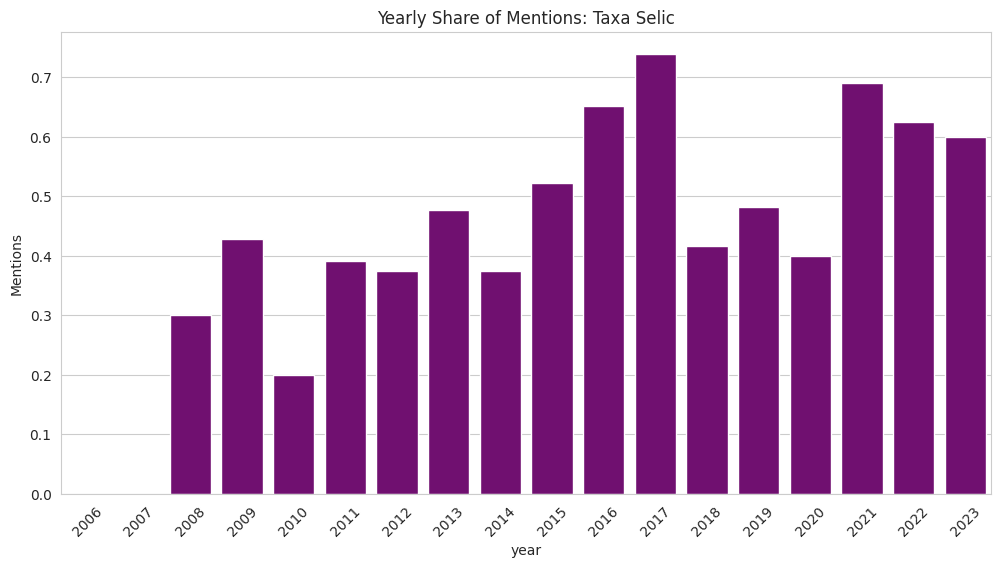

In [22]:
cat = 'Taxa Selic'
x = df_gpt[df_gpt['topic'] == cat].copy()
x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['sentiment'] = x['sentiment'].apply(lambda x: 1 if x == 'Sim' else 0)

x = x.groupby(['topic','year']).agg({'present':'mean','sentiment':'sum'}).reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x=x['year'],y=x['present'], color='purple')

plt.title(f'Yearly Share of Mentions: {cat}')
plt.ylabel('Mentions')
plt.xticks(rotation=45)
plt.show()

### Llama

#### Mentions

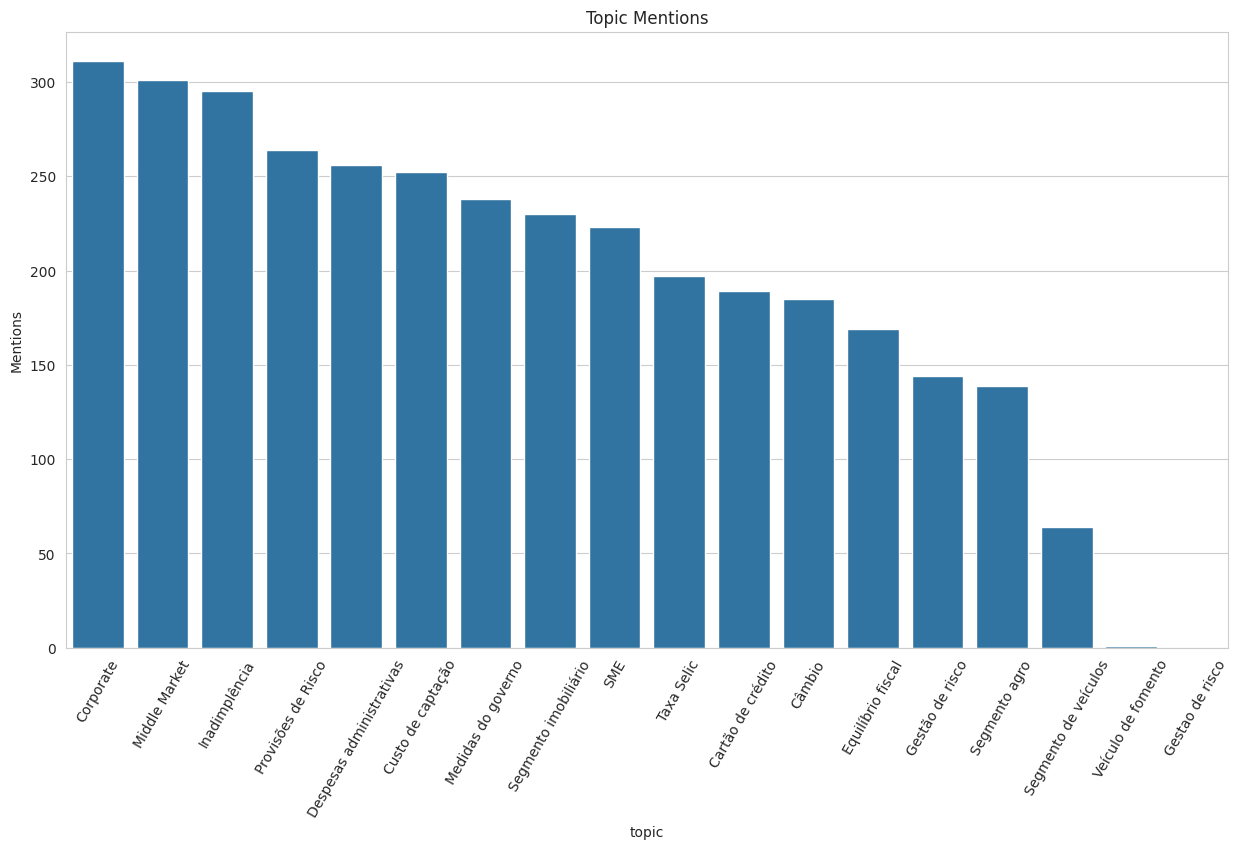

In [30]:
x = df_llama.copy()
x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['sentiment'] = x['sentiment'].apply(lambda x: 1 if x == 'Sim' else 0)
x = x.groupby('topic').agg({'present':'sum'}).reset_index().sort_values('present', ascending=False)

plt.figure(figsize=(15,8))
sns.barplot(data = x, x = 'topic', y = 'present')
plt.title(f'Topic Mentions')
plt.ylabel('Mentions')
plt.xticks(rotation=60)
plt.show()

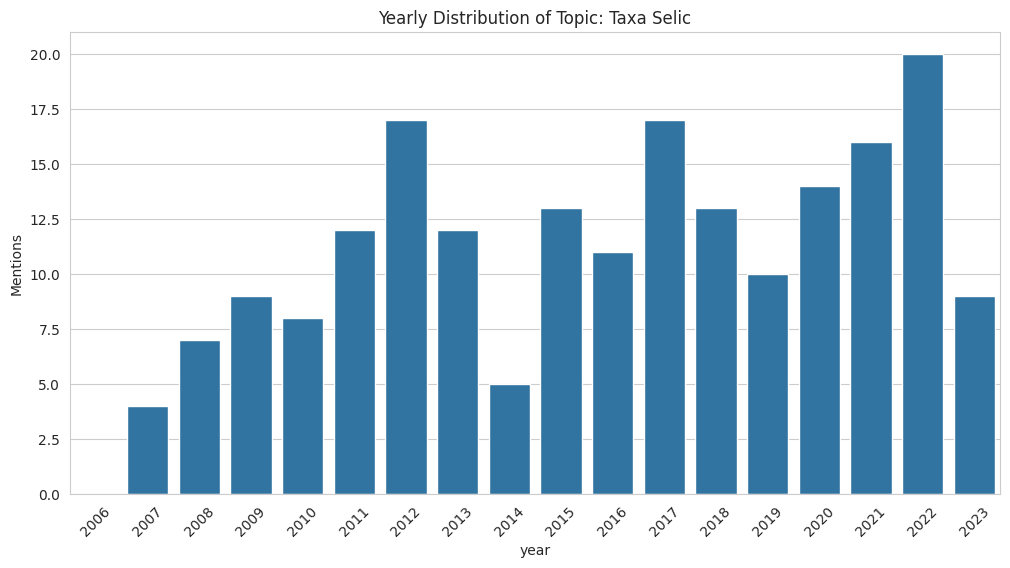

In [27]:
cat = 'Taxa Selic'
x = df_llama[df_llama['topic'] == cat].copy()
x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['sentiment'] = x['sentiment'].apply(lambda x: 1 if x == 'Sim' else 0)

x = x.groupby(['topic','year']).agg({'present':'sum','sentiment':'sum'}).reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x=x['year'],y=x['present'])

plt.title(f'Yearly Distribution of Topic: {cat}')
plt.ylabel('Mentions')
plt.xticks(rotation=45)
plt.show()

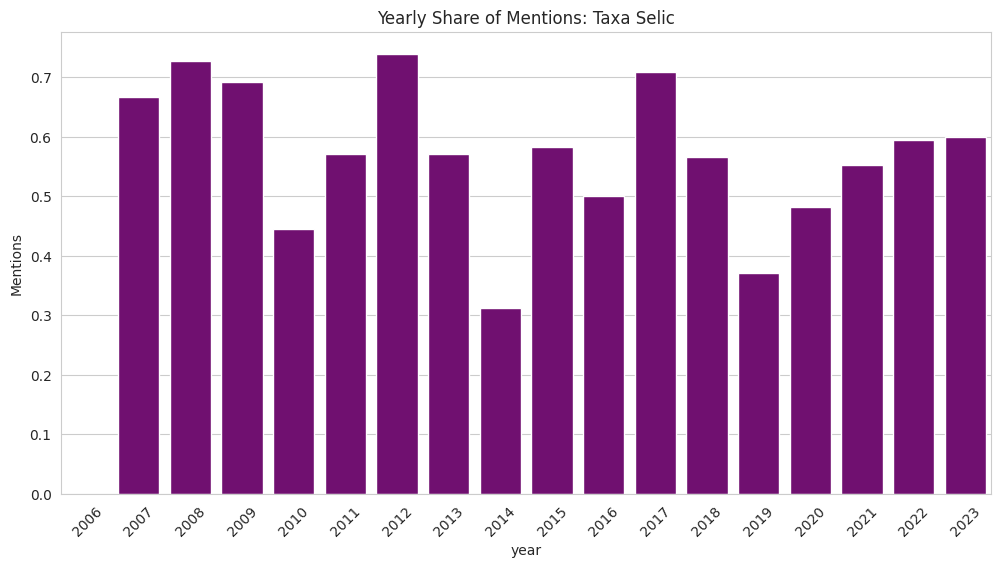

In [ ]:

cat = 'Taxa Selic'
x = df_info[df_info['categories'] == cat].copy()
x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['positive'] = x['positive'].apply(lambda x: 1 if x == 'Sim' else 0)

x = x.groupby(['categories','year']).agg({'present':'mean','positive':'sum'}).reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x=x['year'],y=x['present'], color='purple')

plt.title(f'Yearly Share of Mentions: {cat}')
plt.ylabel('Mentions')
plt.xticks(rotation=45)
plt.show()

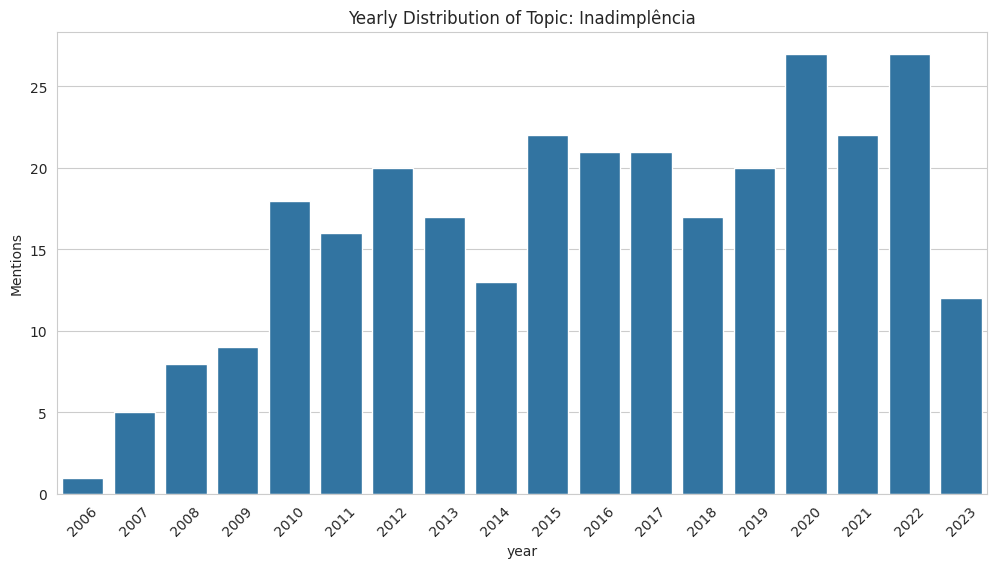

In [ ]:
cat = 'Inadimplência'
x = df_info[df_info['categories'] == cat].copy()
x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['positive'] = x['positive'].apply(lambda x: 1 if x == 'Sim' else 0)

x = x.groupby(['categories','year']).agg({'present':'sum','positive':'sum'}).reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x=x['year'],y=x['present'])

plt.title(f'Yearly Distribution of Topic: {cat}')
plt.ylabel('Mentions')
plt.xticks(rotation=45)
plt.show()

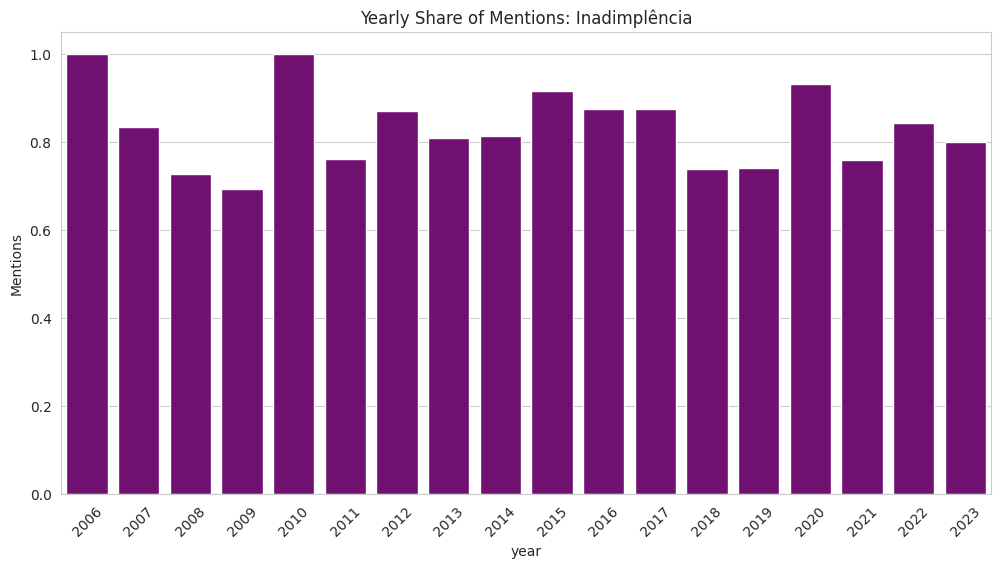

In [ ]:
cat = 'Inadimplência'
x = df_info[df_info['categories'] == cat].copy()
x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['positive'] = x['positive'].apply(lambda x: 1 if x == 'Sim' else 0)

x = x.groupby(['categories','year']).agg({'present':'mean','positive':'sum'}).reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x=x['year'],y=x['present'], color='purple')

plt.title(f'Yearly Share of Mentions: {cat}')
plt.ylabel('Mentions')
plt.xticks(rotation=45)
plt.show()

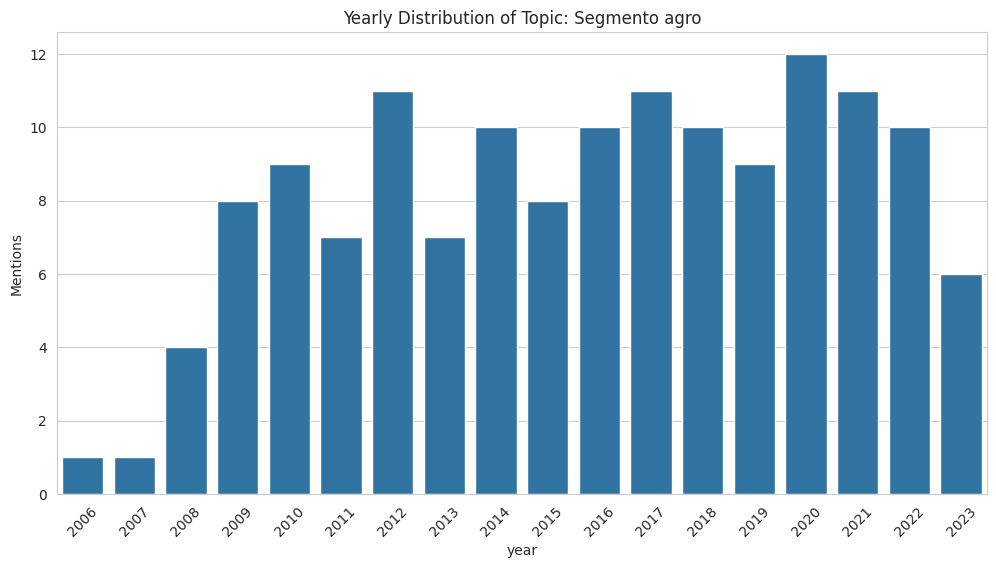

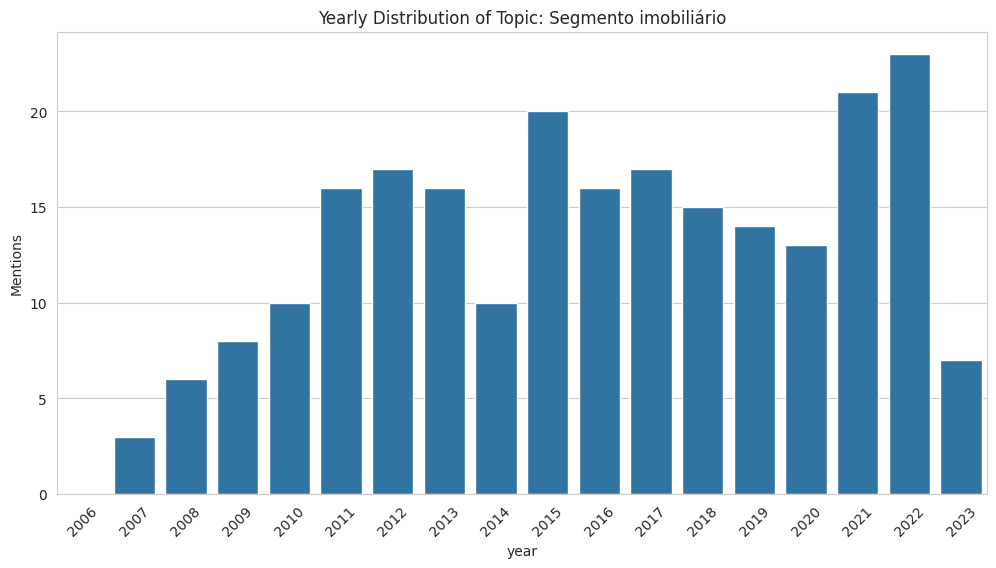

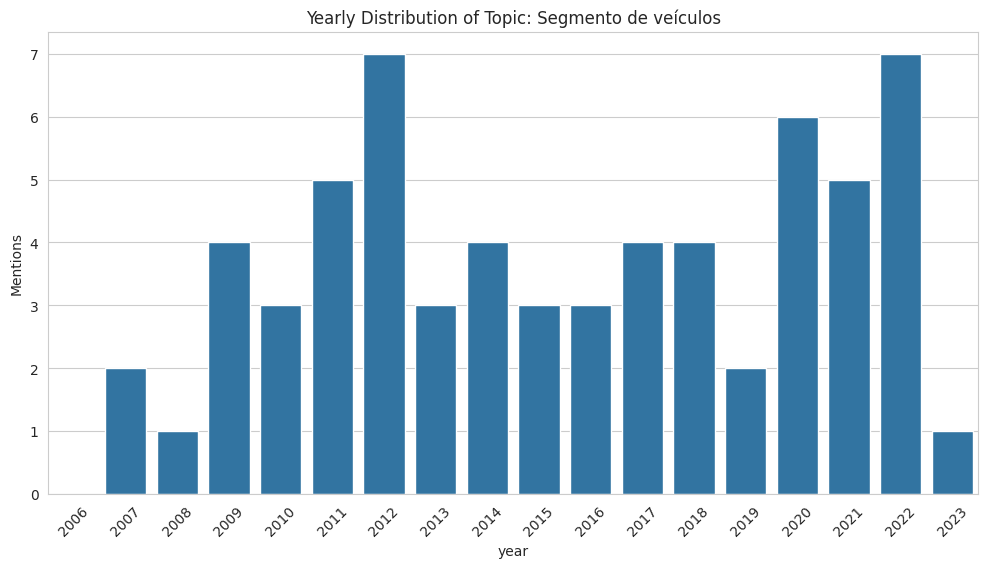

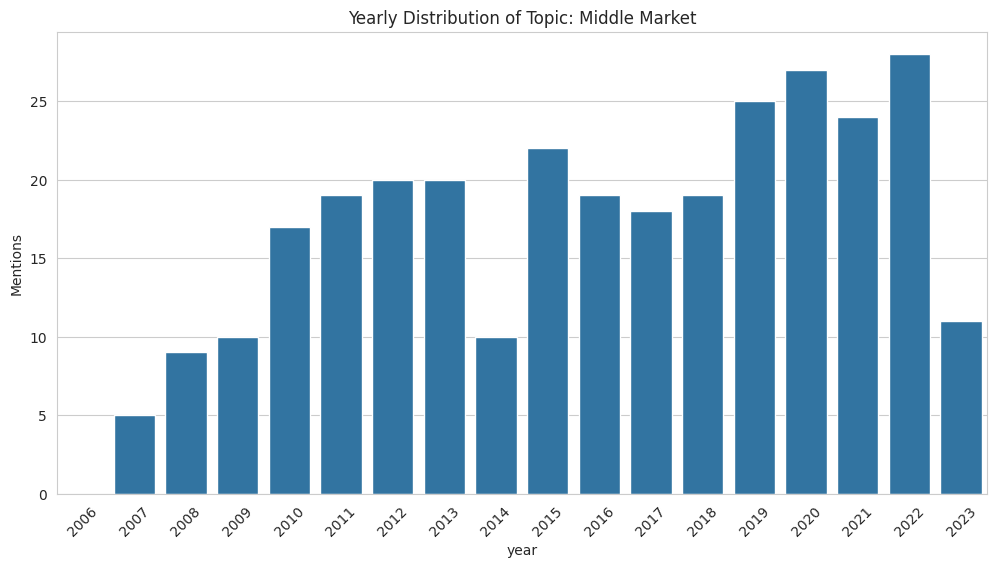

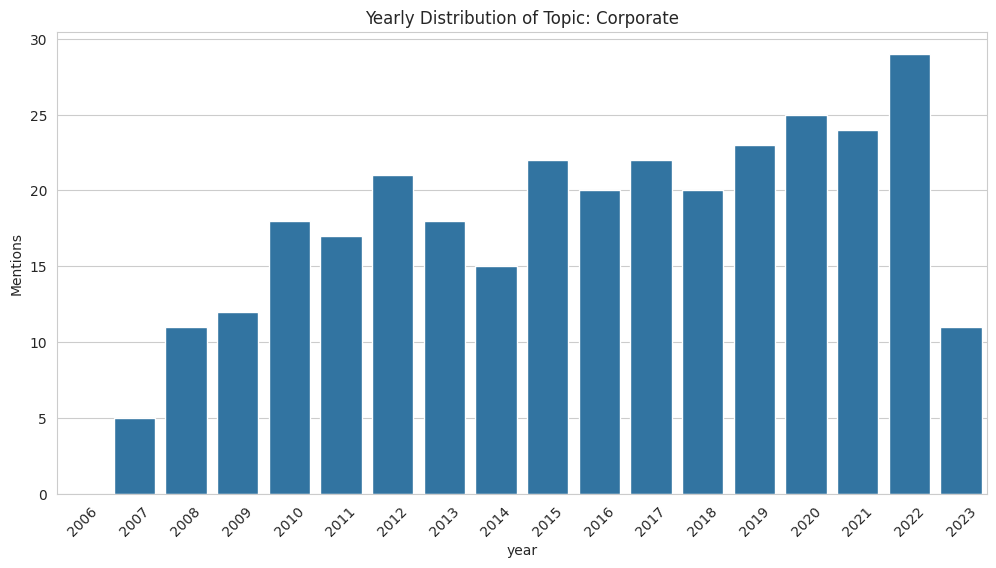

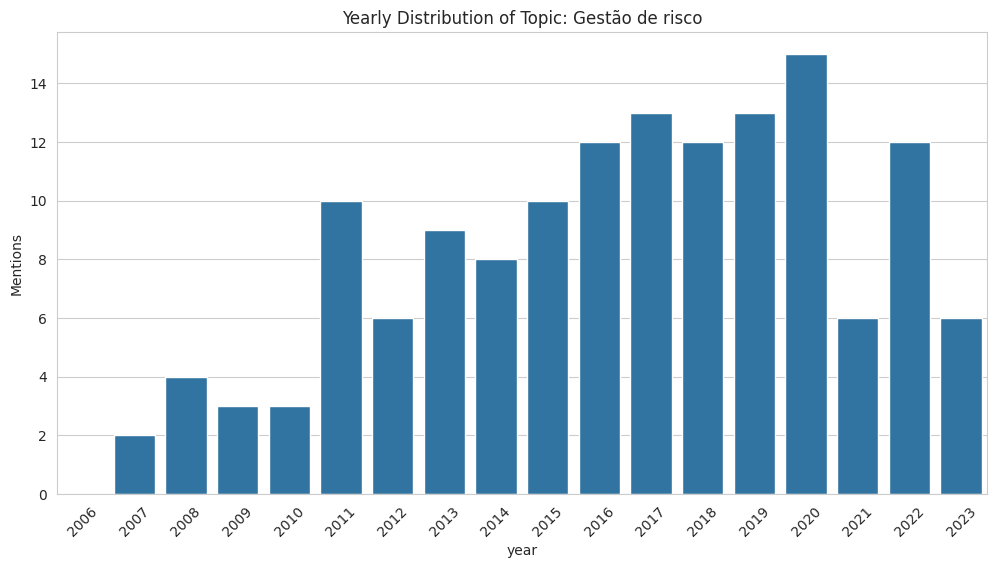

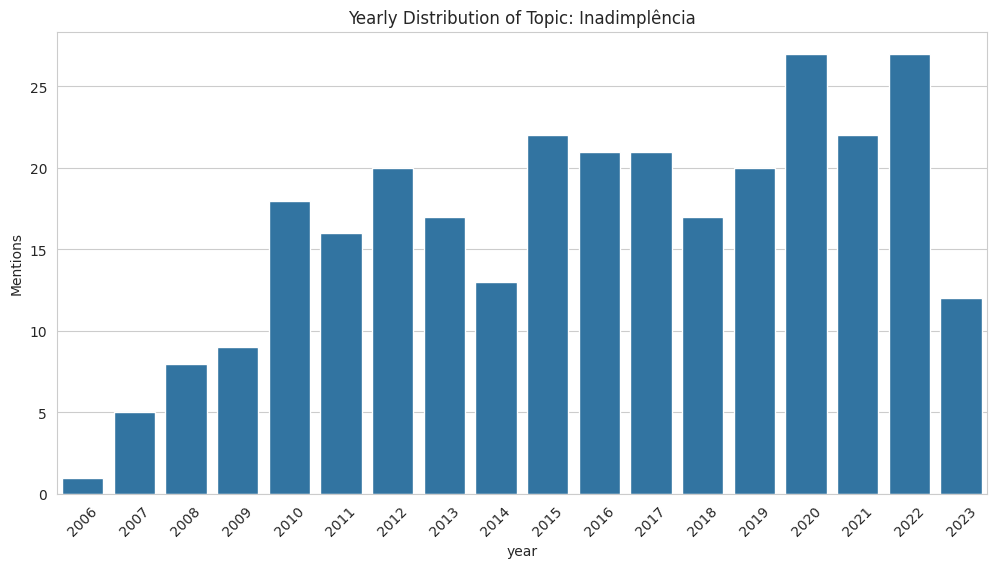

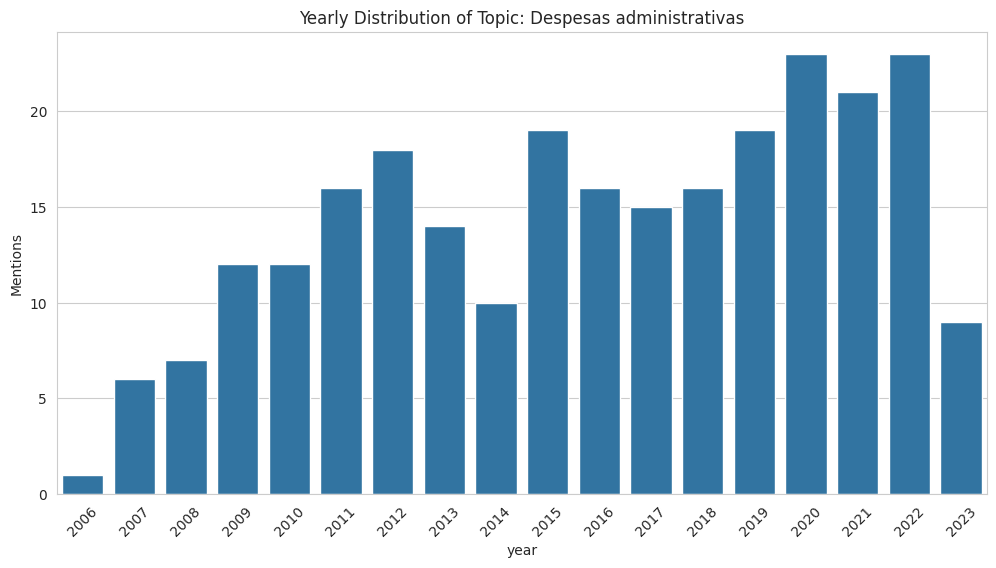

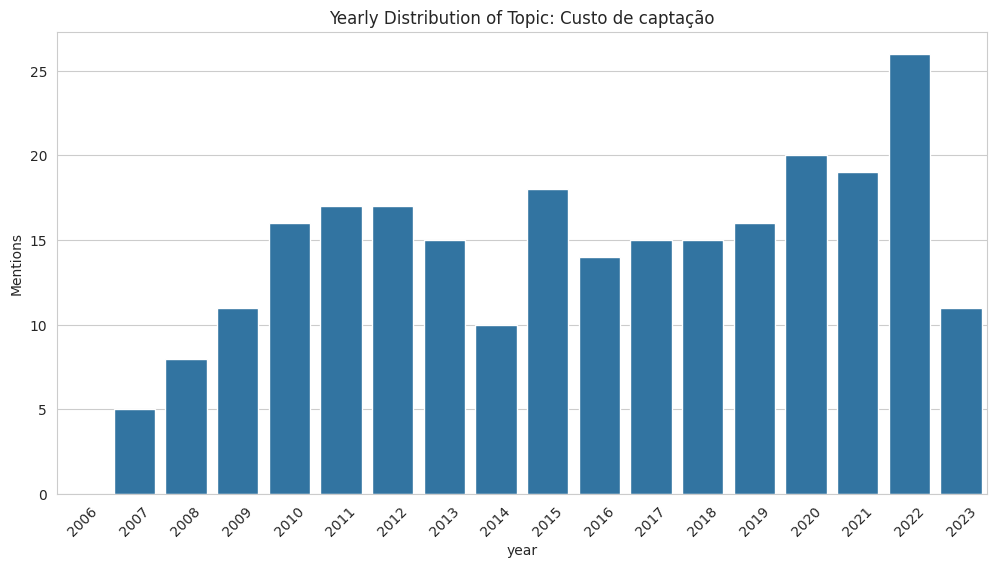

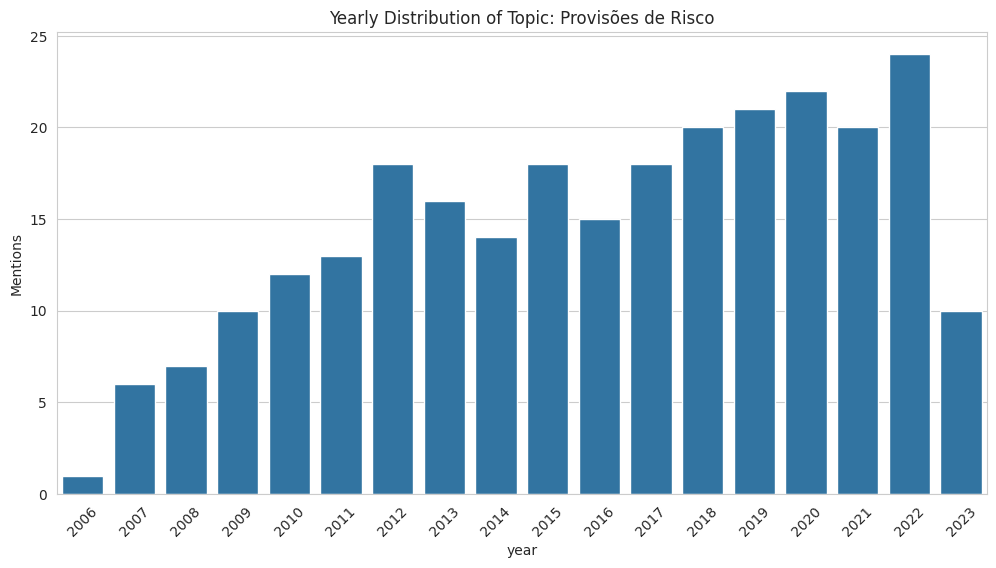

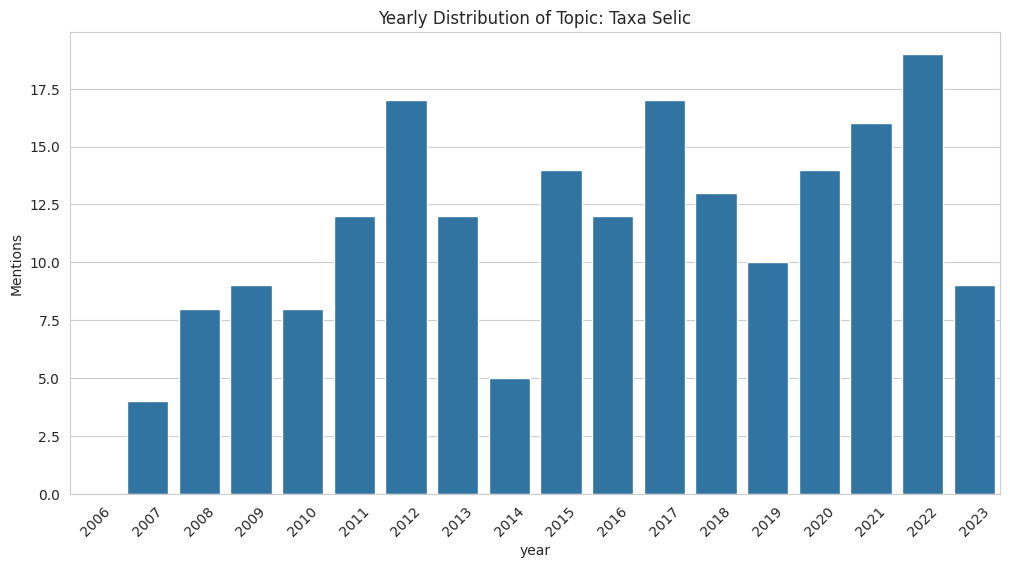

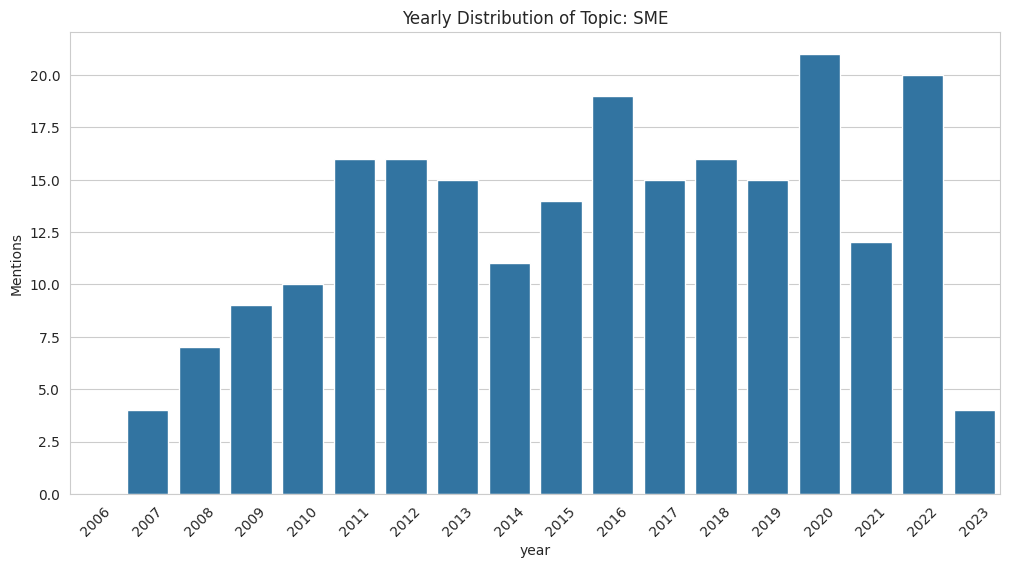

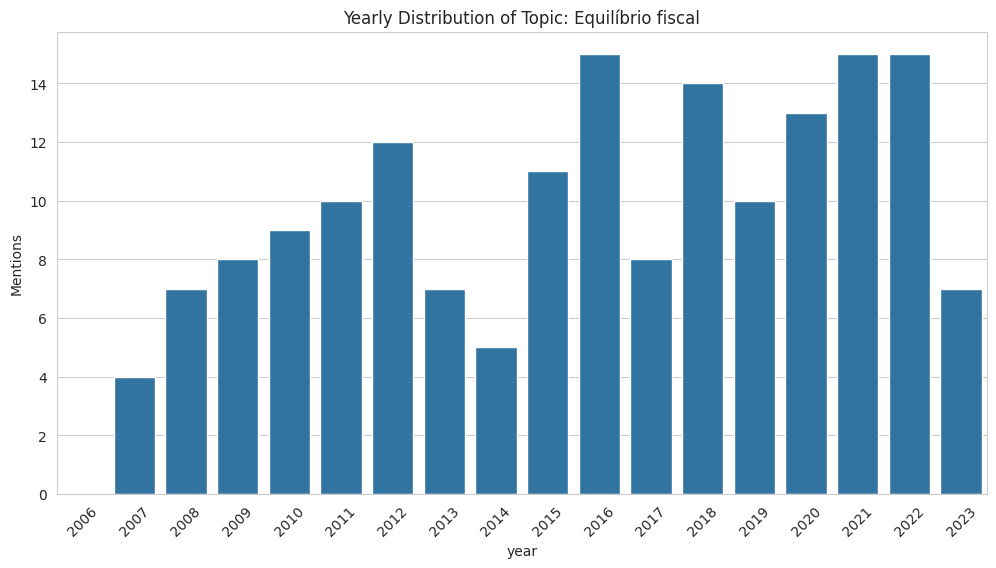

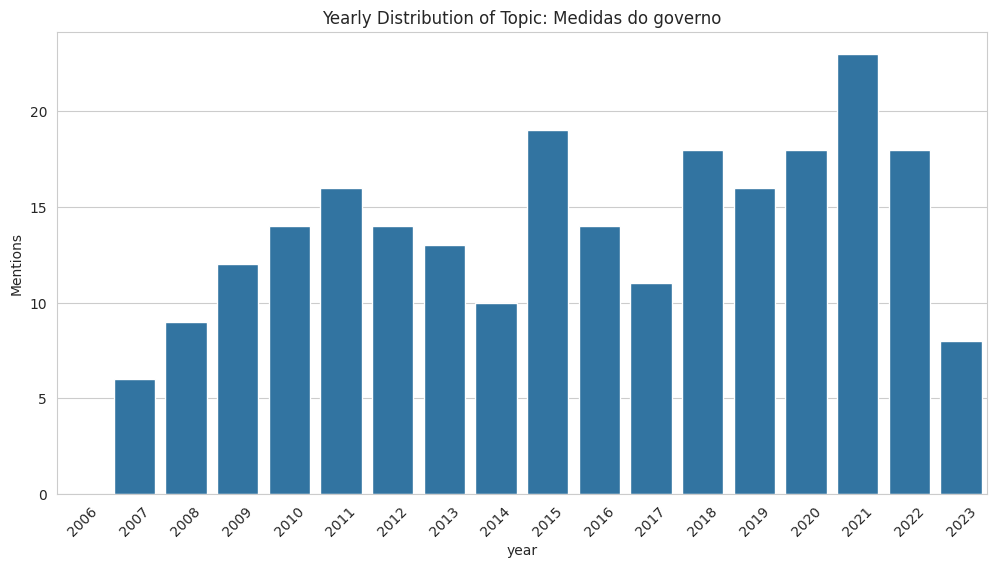

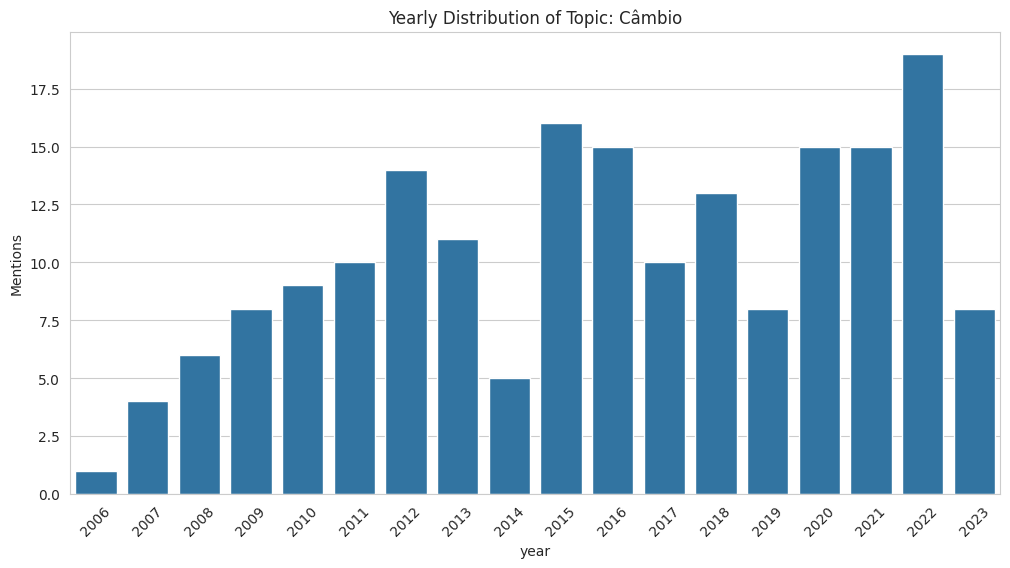

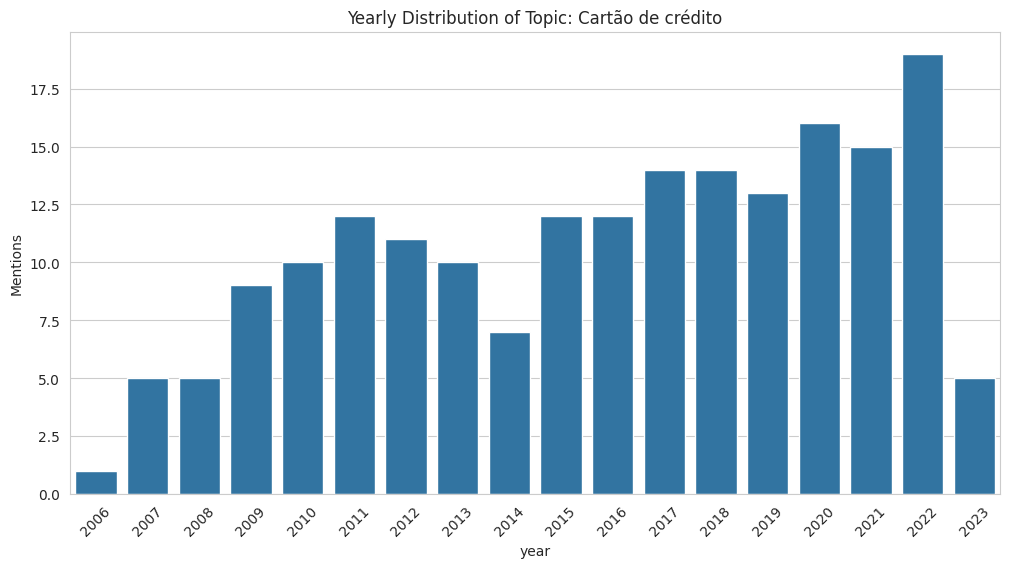

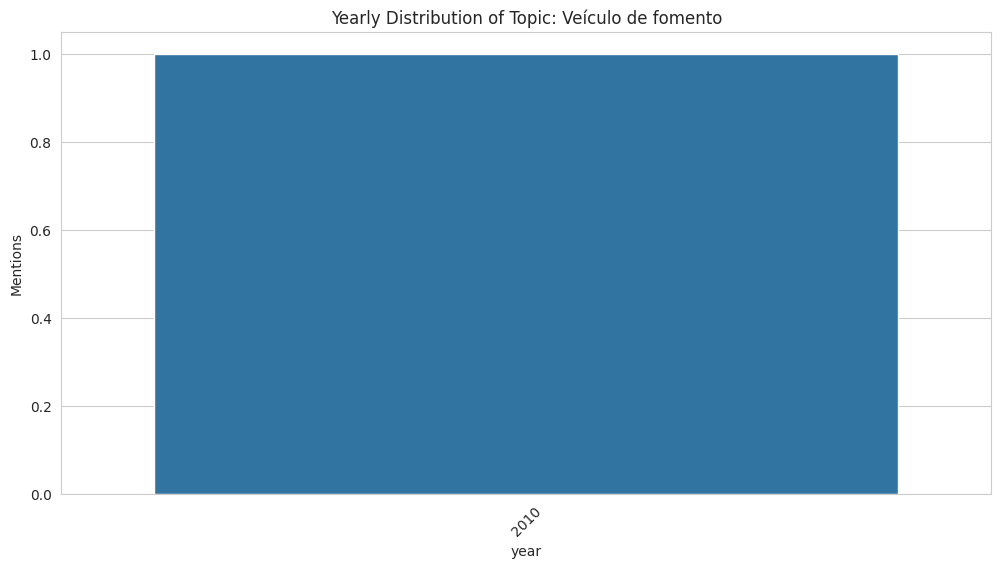

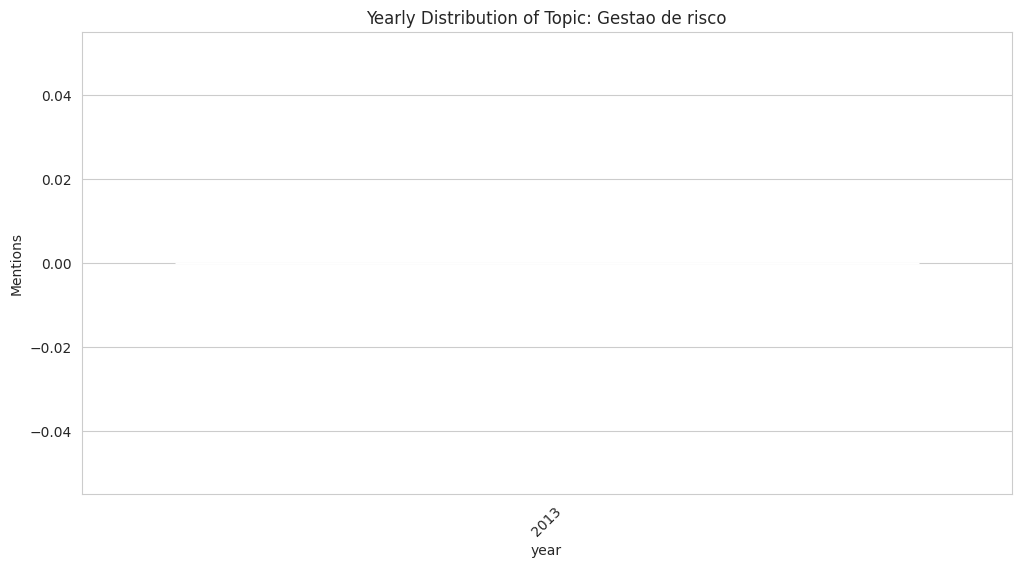

In [ ]:
for cat in df_info['categories'].unique():
  x = df_info[df_info['categories'] == cat].copy()
  x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
  x['positive'] = x['positive'].apply(lambda x: 1 if x == 'Sim' else 0)

  x = x.groupby(['categories','year']).agg({'present':'sum','positive':'sum'}).reset_index()

  plt.figure(figsize=(12,6))
  sns.barplot(x=x['year'],y=x['present'])

  plt.title(f'Yearly Distribution of Topic: {cat}')
  plt.ylabel('Mentions')
  plt.xticks(rotation=45)
  plt.show()

#### Sentiment

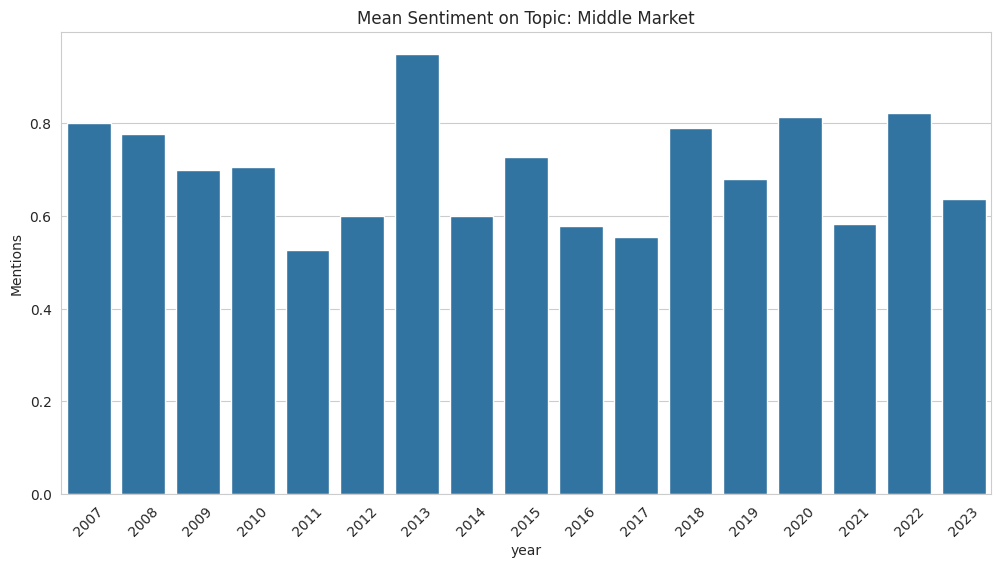

In [ ]:
cat = 'Middle Market'
x = df_info[df_info['categories'] == cat].copy()
x = x[x['present'] == 'Sim']
x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['positive'] = x['positive'].apply(lambda x: 1 if x == 'Sim' else 0)

x = x.groupby(['categories','year']).agg({'positive':'mean'}).reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x=x['year'],y=x['positive'])

plt.title(f'Mean Sentiment on Topic: {cat}')
plt.ylabel('Mentions')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df_info['bank'].unique()

array(['brsr', 'bbdc', 'itub', 'bbas', 'sanb', 'abcb', 'bmgb', 'nu',
       'bpan', 'prbc'], dtype=object)

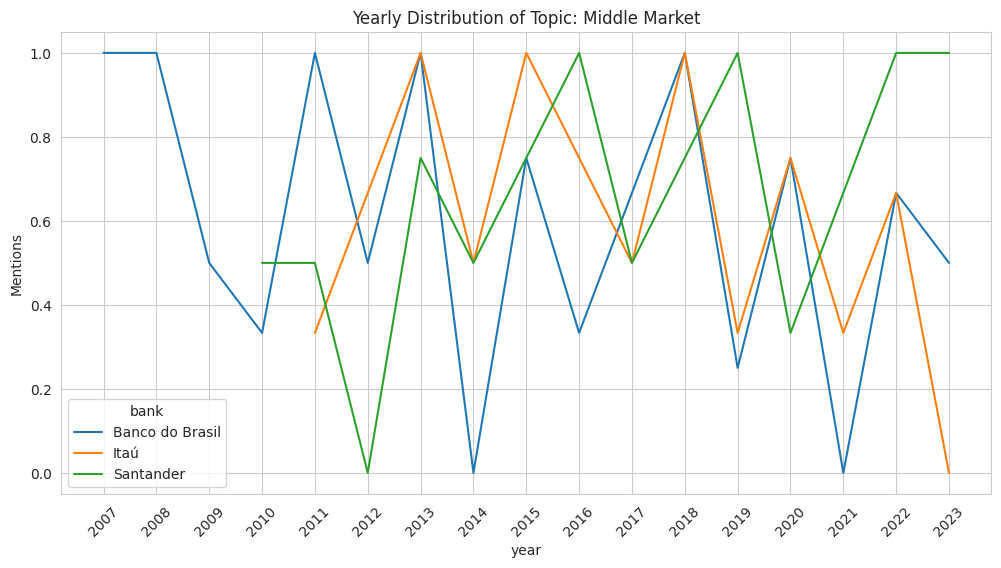

In [ ]:
bank_mapping = {'itub':'Itaú',
                'bbas':'Banco do Brasil',
                'sanb':'Santander'}

cat = 'Middle Market'
x = df_info[df_info['categories'] == cat].copy()
x = x[x['bank'].isin(['itub','bbas','sanb'])]
x['bank'] = x['bank'].replace(bank_mapping)

x = x[x['present'] == 'Sim']
x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['positive'] = x['positive'].apply(lambda x: 1 if x == 'Sim' else 0)

x = x.groupby(['categories','bank','year']).agg({'positive':'mean'}).reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(x=x['year'],y=x['positive'],hue=x['bank'])

plt.title(f'Yearly Distribution of Topic: {cat}')
plt.ylabel('Mentions')
plt.xticks(rotation=45)
plt.show()

#### Bank Specific

In [ ]:
df_info['bank'].unique()

array(['brsr', 'bbdc', 'itub', 'bbas', 'sanb', 'abcb', 'bmgb', 'nu',
       'bpan', 'prbc'], dtype=object)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, 'Corporate'),
  Text(1, 0, 'Provisões de Risco'),
  Text(2, 0, 'Inadimplência'),
  Text(3, 0, 'Despesas administrativas'),
  Text(4, 0, 'Middle Market'),
  Text(5, 0, 'Segmento imobiliário'),
  Text(6, 0, 'Custo de captação'),
  Text(7, 0, 'Medidas do governo'),
  Text(8, 0, 'Taxa Selic'),
  Text(9, 0, 'Equilíbrio fiscal'),
  Text(10, 0, 'Gestão de risco'),
  Text(11, 0, 'SME'),
  Text(12, 0, 'Cartão de crédito'),
  Text(13, 0, 'Câmbio'),
  Text(14, 0, 'Segmento agro'),
  Text(15, 0, 'Segmento de veículos')])

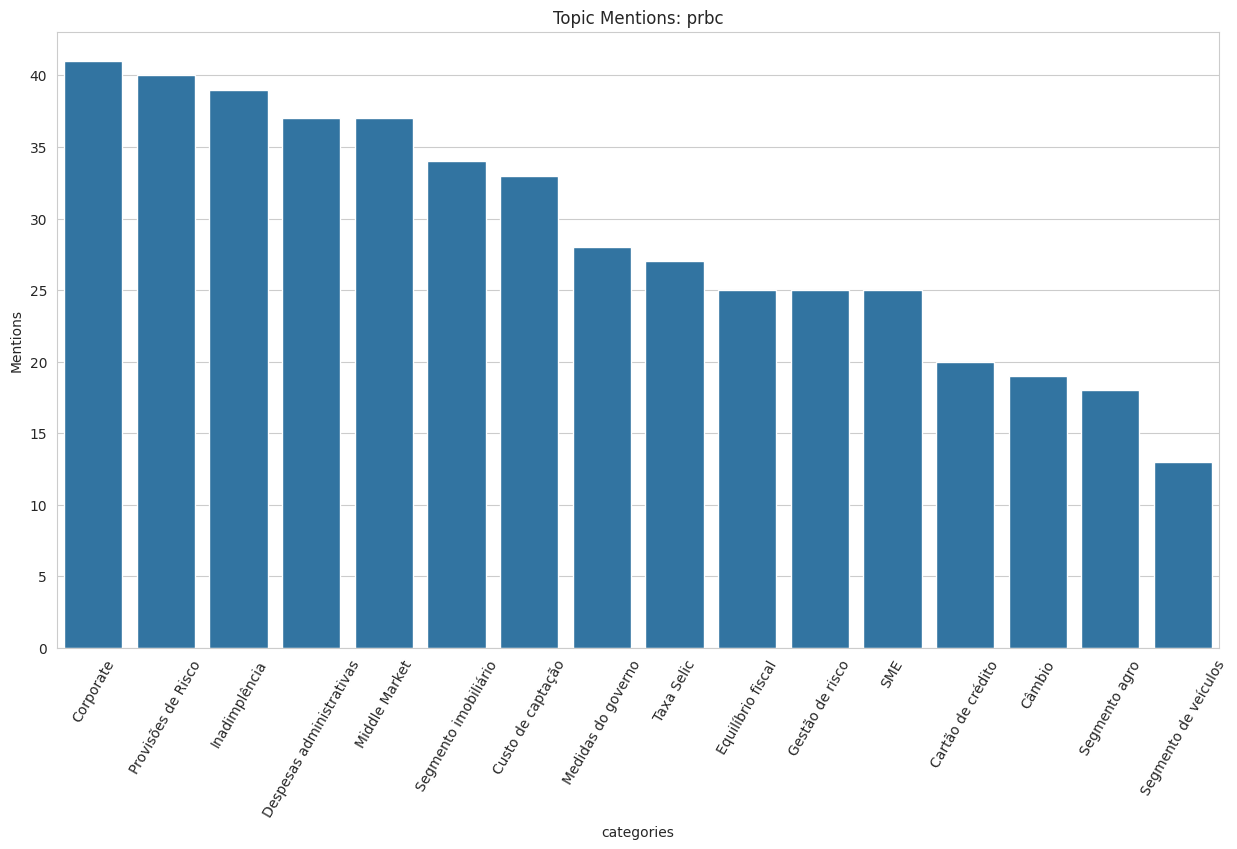

In [ ]:
bank = 'prbc'
x = df_info[df_info['bank'] == 'itub'].copy()
x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['positive'] = x['positive'].apply(lambda x: 1 if x == 'Sim' else 0)
x = x.groupby('categories').agg({'present':'sum'}).reset_index().sort_values('present', ascending=False)

plt.figure(figsize=(15,8))
sns.barplot(data = x, x = 'categories', y = 'present')
plt.title(f'Topic Mentions: {bank}')
plt.ylabel('Mentions')
plt.xticks(rotation=60)

In [ ]:
path_cotacoes = '/content/drive/MyDrive/Portfolio Projects/Mestrado/Cotações'
cotacoes_lis = os.listdir(path_cotacoes)
total_path_cotacoes = os.path.join(path_cotacoes, cotacoes_lis[0])
print(total_path_cotacoes)
df_cotacoes_bb = pd.read_csv(total_path_cotacoes, sep=';')

df_cotacoes_bb.columns = df_cotacoes_bb.iloc[0]
df_cotacoes_bb = df_cotacoes_bb[1:]
df_cotacoes_bb.reset_index(drop=True, inplace=True)
df_cotacoes_bb['Abertura'] = df_cotacoes_bb['Abertura'].apply(lambda x: x.replace(',','.'))

# Convert the 'Date' column
df_cotacoes_bb['Data'] = pd.to_datetime(df_cotacoes_bb['Data'], format='%d/%m/%Y')
# Define the first days of each quarter
first_days_of_quarters = df_cotacoes_bb['Data'].dt.is_quarter_start
# Filter the DataFrame to keep only the first day of each quarter
df_cotacoes_bb = df_cotacoes_bb[first_days_of_quarters]

df_cotacoes_bb['Abertura'] = df_cotacoes_bb['Abertura'].astype(float)
df_cotacoes_bb.head()

/content/drive/MyDrive/Portfolio Projects/Mestrado/Cotações/Histórico de Cotações-20241121 - BB.csv


,Data,Abertura,Máxima,Mínima,Fechado,Média,Variação,Volume,Quantidade de Ações,Negócios
249,2022-07-01,13.54,"13,66","13,44","13,58","13,53","-0,68 %",275857792,8347800,26395
311,2022-04-01,14.01,"14,06","13,75","13,9","13,92","-0,05 %",906718080,26102900,41542
434,2021-10-01,11.14,"11,36","11,09","11,34","11,28","2,24 %",274470016,9342400,19650
498,2021-07-01,12.18,"12,23","11,99","12,02","12,06","-1,05 %",329410176,10320700,22547
560,2021-04-01,11.46,"11,47","11,13","11,15","11,21","-1,64 %",389320992,12932500,41140


<Figure size 1500x600 with 0 Axes>

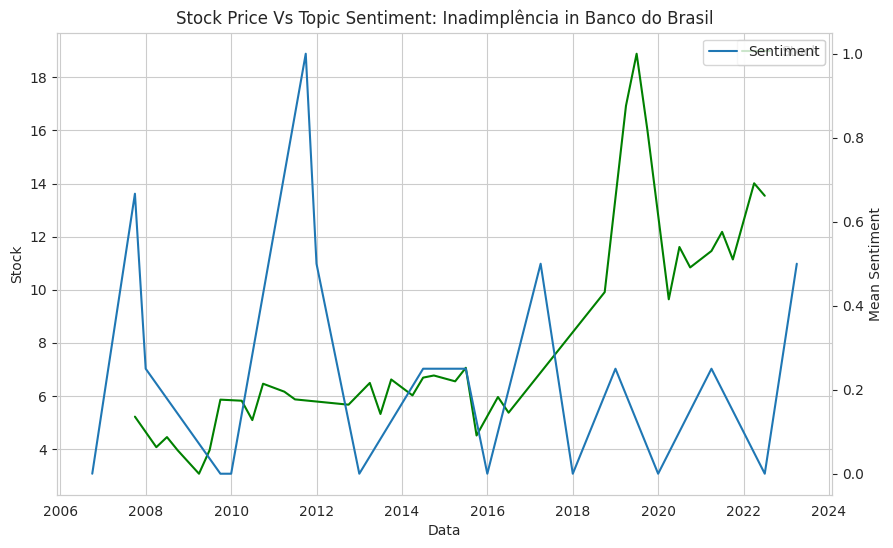

In [ ]:
cat = 'Inadimplência'
bank = 'Banco do Brasil'
x = df_info[df_info['bank'] == 'bbas'].copy()
x = x[x['categories'] == cat].copy()

x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['positive'] = x['positive'].apply(lambda x: 1 if x == 'Sim' else 0)

x['Data'] = x.apply(lambda x: '01/01' if x['trimester'] == '1' else ('01/04' if x['trimester'] == '2' else ('01/07' if x['trimester'] == '3' else '01/10')), axis=1) + '/' + x['year'].astype(str)
x['Data'] = pd.to_datetime(x['Data'], format='%d/%m/%Y')

x = x.groupby('year').agg({'Data':'first','positive':'mean'}).reset_index()#.sort_values('positive', ascending=False)

plt.figure(figsize=(15, 6))
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.lineplot(x = df_cotacoes_bb['Data'], y = df_cotacoes_bb['Abertura'], ax=ax1, color = 'green', label = 'Stock')

ax2 = ax1.twinx()
sns.lineplot(x = x['Data'], y = x['positive'], ax = ax2, label = 'Sentiment')

#ax2.yaxis.set_label_coords(0.1, 0.5)
ax2.grid(False)

plt.xticks(rotation=70)
plt.title(f'Stock Price Vs Topic Sentiment: {cat} in {bank}')
ax1.set_ylabel('Stock')
ax2.set_ylabel('Mean Sentiment')
plt.show()

## Model Comparison

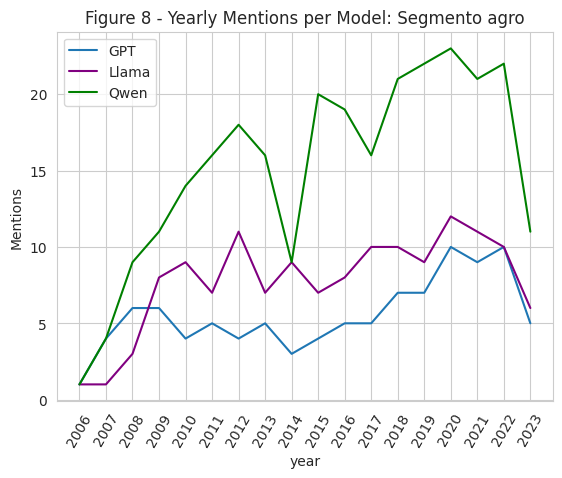

In [61]:
cat = df_gpt['topic'].unique()[0]
x = df_gpt[df_gpt['topic'] == cat].copy()
y = df_llama[df_llama['topic'] == cat].copy()
z = df_qwen[df_qwen['topic'] == cat].copy()

x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['sentiment'] = x['sentiment'].apply(lambda x: 1 if x == 'Sim' else 0)
y['present'] = y['present'].apply(lambda x: 1 if x == 'Sim' else 0)
y['sentiment'] = y['sentiment'].apply(lambda x: 1 if x == 'Sim' else 0)
z['present'] = z['present'].apply(lambda x: 1 if x == 'Sim' else 0)
z['sentiment'] = z['sentiment'].apply(lambda x: 1 if x == 'Sim' else 0)

x = x.groupby('year').agg({'present':'sum'}).reset_index()
y = y.groupby('year').agg({'present':'sum'}).reset_index()
z = z.groupby('year').agg({'present':'sum'}).reset_index()

sns.lineplot(y = x['present'], x = x['year'],label='GPT')
sns.lineplot(y = y['present'], x = y['year'], color='purple', label = 'Llama')
sns.lineplot(y = z['present'], x = z['year'], color='green', label = 'Qwen')

plt.xticks(rotation=60)
plt.title(f'Figure 8 - Yearly Mentions per Model: {cat}')
plt.ylabel('Mentions')
plt.show()

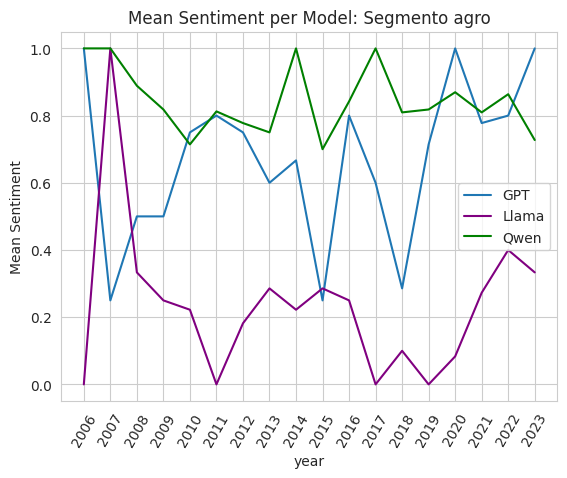

In [161]:
cat = df_gpt['topic'].unique()[0]
x = df_gpt[df_gpt['topic'] == cat].copy()
y = df_llama[df_llama['topic'] == cat].copy()
z = df_qwen[df_qwen['topic'] == cat].copy()

x = x[x['present'] == 'Sim'].copy()
y = y[y['present'] == 'Sim'].copy()
z = z[z['present'] == 'Sim'].copy()
x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['sentiment'] = x['sentiment'].apply(lambda x: 1 if x == 'Sim' else 0)
y['present'] = y['present'].apply(lambda x: 1 if x == 'Sim' else 0)
y['sentiment'] = y['sentiment'].apply(lambda x: 1 if x == 'Sim' else 0)
z['present'] = z['present'].apply(lambda x: 1 if x == 'Sim' else 0)
z['sentiment'] = z['sentiment'].apply(lambda x: 1 if x == 'Sim' else 0)

x = x.groupby('year').agg({'sentiment':'mean'}).reset_index()
y = y.groupby('year').agg({'sentiment':'mean'}).reset_index()
z = z.groupby('year').agg({'sentiment':'mean'}).reset_index()

sns.lineplot(y = x['sentiment'], x = x['year'],label='GPT')
sns.lineplot(y = y['sentiment'], x = y['year'], color='purple', label = 'Llama')
sns.lineplot(y = z['sentiment'], x = z['year'], color='green', label = 'Qwen')

plt.xticks(rotation=60)
plt.title(f'Mean Sentiment per Model: {cat}')
plt.ylabel('Mean Sentiment')
plt.show()

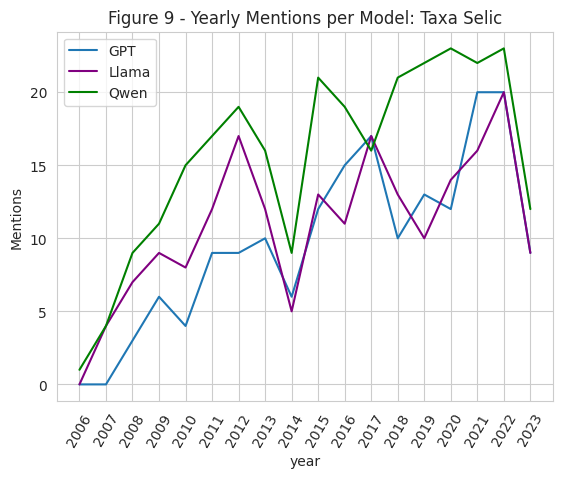

In [62]:
cat = 'Taxa Selic'
x = df_gpt[df_gpt['topic'] == cat].copy()
y = df_llama[df_llama['topic'] == cat].copy()
z = df_qwen[df_qwen['topic'] == cat].copy()
y.rename(columns={'topic':'topic'}, inplace=True)

x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['sentiment'] = x['sentiment'].apply(lambda x: 1 if x == 'Sim' else 0)
y['present'] = y['present'].apply(lambda x: 1 if x == 'Sim' else 0)
y['sentiment'] = y['sentiment'].apply(lambda x: 1 if x == 'Sim' else 0)
z['present'] = z['present'].apply(lambda x: 1 if x == 'Sim' else 0)
z['sentiment'] = z['sentiment'].apply(lambda x: 1 if x == 'Sim' else 0)

x = x.groupby('year').agg({'present':'sum'}).reset_index()
y = y.groupby('year').agg({'present':'sum'}).reset_index()
z = z.groupby('year').agg({'present':'sum'}).reset_index()

sns.lineplot(y = x['present'], x = x['year'],label='GPT')
sns.lineplot(y = y['present'], x = y['year'], color='purple', label = 'Llama')
sns.lineplot(y = z['present'], x = z['year'], color='green', label = 'Qwen')
plt.xticks(rotation=60)
plt.title(f'Figure 9 - Yearly Mentions per Model: {cat}')
plt.ylabel('Mentions')
plt.show()

In [76]:
cat = 'Taxa Selic'
x = df_gpt[df_gpt['topic'] == cat].copy()
y = df_llama[df_llama['topic'] == cat].copy()
z = df_qwen[df_qwen['topic'] == cat].copy()

x = x[x['present'] == 'Sim'].copy()
y['present'] = y['present'].apply(lambda x: 1 if x == 'Sim' else 0)
y['sentiment'] = y['sentiment'].apply(lambda x: 1 if x == 'Sim' else 0)
#x = x.groupby('year').agg({'sentiment':'mean'}).reset_index()
x.head()

,doc,topic,present,sentiment,bank,year,trimester
10,bmgb-2022-2,Taxa Selic,Sim,Não,bmgb,2022,2
42,abcb-2022-3,Taxa Selic,Sim,Sim,abcb,2022,3
186,brsr-2019-3,Taxa Selic,Sim,Sim,brsr,2019,3
218,bbas-2018-2,Taxa Selic,Sim,Não,bbas,2018,2
234,prbc-2010-1,Taxa Selic,Sim,Não,prbc,2010,1


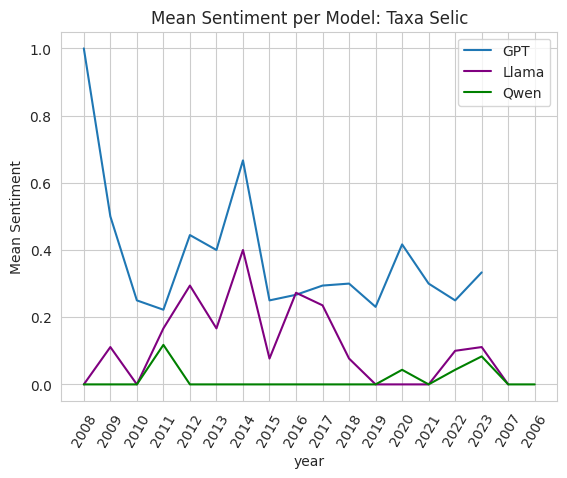

In [77]:
cat = 'Taxa Selic'
x = df_gpt[df_gpt['topic'] == cat].copy()
y = df_llama[df_llama['topic'] == cat].copy()
z = df_qwen[df_qwen['topic'] == cat].copy()

x = x[x['present'] == 'Sim'].copy()
y = y[y['present'] == 'Sim'].copy()
z = z[z['present'] == 'Sim'].copy()
x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['sentiment'] = x['sentiment'].apply(lambda x: 1 if x == 'Sim' else 0)
y['present'] = y['present'].apply(lambda x: 1 if x == 'Sim' else 0)
y['sentiment'] = y['sentiment'].apply(lambda x: 1 if x == 'Sim' else 0)
z['present'] = z['present'].apply(lambda x: 1 if x == 'Sim' else 0)
z['sentiment'] = z['sentiment'].apply(lambda x: 1 if x == 'Sim' else 0)

x = x.groupby('year').agg({'sentiment':'mean'}).reset_index()
y = y.groupby('year').agg({'sentiment':'mean'}).reset_index()
z = z.groupby('year').agg({'sentiment':'mean'}).reset_index()

sns.lineplot(y = x['sentiment'], x = x['year'],label='GPT')
sns.lineplot(y = y['sentiment'], x = y['year'], color='purple', label = 'Llama')
sns.lineplot(y = z['sentiment'], x = z['year'], color='green', label = 'Qwen')
plt.xticks(rotation=60)
plt.title(f'Mean Sentiment per Model: {cat}')
plt.ylabel('Mean Sentiment')
plt.show()